In [1]:
import pandas as pd

# Load your datasets (**replaced the event study abnormal returns csv with corrected version**)
df_ar = pd.read_csv("event_study_abnormal_returns_panel_10_20_v2.csv")
df_reg = pd.read_csv("full_event_regimes.csv")

In [2]:
df_ar.head()

,event_id,ticker,date,event_day,abnormal_return
0,AAPL_2005-07-13,AAPL,2005-07-05,-8,0.026191
1,AAPL_2005-07-13,AAPL,2005-07-06,-7,-0.006099
2,AAPL_2005-07-13,AAPL,2005-07-07,-6,-0.006843
3,AAPL_2005-07-13,AAPL,2005-07-08,-5,-0.011699
4,AAPL_2005-07-13,AAPL,2005-07-11,-2,-0.027788


In [3]:
df_reg.head()

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime,symbol,totalRevenue,grossProfit,...,event_id,ticker,revenue_growth,margin_trend,profitability,revenue_growth_regime,eps_surprise_regime,profitability_regime,margin_trend_regime,financial_strength_regime
0,2005-09-30,2005-10-11,0.01,0.01,0.0,0.0,post-market,AAPL,3678000000,1035000000,...,AAPL_2005-09-30,AAPL,NaN,NaN,0.113649,missing,small,medium,missing,mixed
1,2005-12-31,2006-01-18,0.02,0.02,0.0,0.0,post-market,AAPL,5749000000,1564000000,...,AAPL_2005-12-31,AAPL,0.563078,-0.018633,0.130457,high_growth,small,medium,contraction,mixed
2,2006-03-31,2006-04-19,0.02,0.02,0.0,0.0,post-market,AAPL,4359000000,1297000000,...,AAPL_2006-03-31,AAPL,-0.241781,-0.004220,0.121358,negative_growth,small,medium,stable,mixed
3,2006-06-30,2006-07-19,0.02,0.02,0.0,0.0,post-market,AAPL,4370000000,1325000000,...,AAPL_2006-06-30,AAPL,0.002524,0.013951,0.129519,moderate_growth,small,medium,expansion,mixed
4,2006-09-30,2006-10-18,0.02,0.02,0.0,0.0,post-market,AAPL,4370000000,1412000000,...,AAPL_2006-09-30,AAPL,0.000000,0.016018,0.139130,moderate_growth,small,medium,expansion,mixed


In [4]:
# (**Fix for incorrect event_id column in full_event_regimes csv**)

# Ensure reportedDate is datetime
df_reg["reportedDate"] = pd.to_datetime(df_reg["reportedDate"], errors="coerce")

# Build event_id that matches your corrected event-study panel (ticker + reportedDate)
df_reg["event_id_reported"] = (
    df_reg["ticker"].astype(str) + "_" + df_reg["reportedDate"].dt.strftime("%Y-%m-%d")
)

In [5]:
# Compute CAR windows for each event
def compute_car(df_ar, t1, t2, label):
    car = (
        df_ar[(df_ar["event_day"] >= t1) & (df_ar["event_day"] <= t2)]
        .groupby("event_id")["abnormal_return"]
        .sum()
        .reset_index()
        .rename(columns={"abnormal_return": label})
    )
    return car

car_m1_p1 = compute_car(df_ar, -1, 1, "CAR_m1_p1")
car_m2_p2 = compute_car(df_ar, -2, 2, "CAR_m2_p2")
car_m5_p5 = compute_car(df_ar, -5, 5, "CAR_m5_p5")

In [6]:
# Merge CAR windows into the event‑level dataset (**Change the merges to use the new key**)
df = df_reg.copy()

df = df.merge(
    car_m1_p1,
    left_on="event_id_reported",
    right_on="event_id",
    how="left"
).drop(columns=["event_id"], errors="ignore")

df = df.merge(
    car_m2_p2,
    left_on="event_id_reported",
    right_on="event_id",
    how="left"
).drop(columns=["event_id"], errors="ignore")

df = df.merge(
    car_m5_p5,
    left_on="event_id_reported",
    right_on="event_id",
    how="left"
).drop(columns=["event_id"], errors="ignore")

In [7]:
# Add EPS‑surprise binary variable
df["eps_bin2"] = (df["surprise"] > 0).astype(int)

In [8]:
# Split the dataset by company
companies = ["AAPL", "GOOGL", "NVDA"]
company_data = {c: df[df["ticker"] == c].copy() for c in companies}


In [9]:
# Company‑level regressions (AR and CAR windows)
import statsmodels.api as sm

def run_regression(df, y_col):
    X = sm.add_constant(df[["eps_bin2"]])
    y = df[y_col]
    return sm.OLS(y, X).fit()

results = {}

for c in companies:
    d = company_data[c]
    results[c] = {
        "AR0": run_regression(d, "AR0") if "AR0" in d.columns else None,
        "CAR_m1_p1": run_regression(d, "CAR_m1_p1"),
        "CAR_m2_p2": run_regression(d, "CAR_m2_p2"),
        "CAR_m5_p5": run_regression(d, "CAR_m5_p5"),
    }


In [10]:
for c in companies:
    print(f"\n=== {c} ===")
    for k, model in results[c].items():
        if model is not None:
            print(f"\n--- {k} ---")
            print(model.summary())


=== AAPL ===

--- CAR_m1_p1 ---
                            OLS Regression Results                            
Dep. Variable:              CAR_m1_p1   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.197
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.142
Time:                        12:08:04   Log-Likelihood:                 135.52
No. Observations:                  81   AIC:                            -267.0
Df Residuals:                      79   BIC:                            -262.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.00

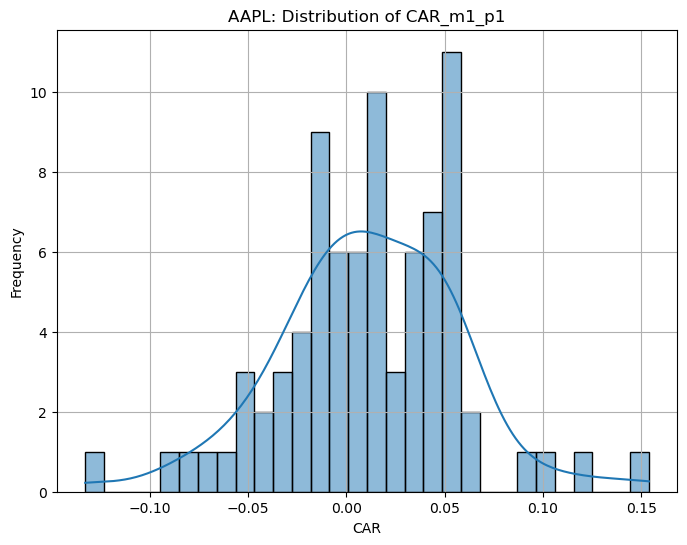

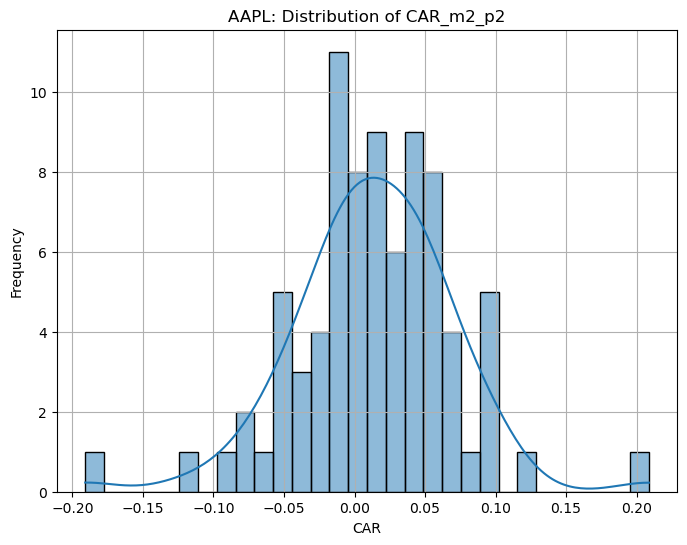

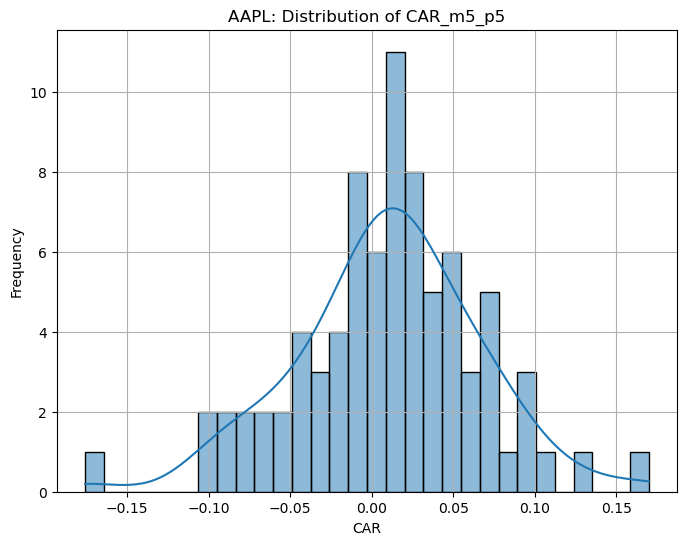

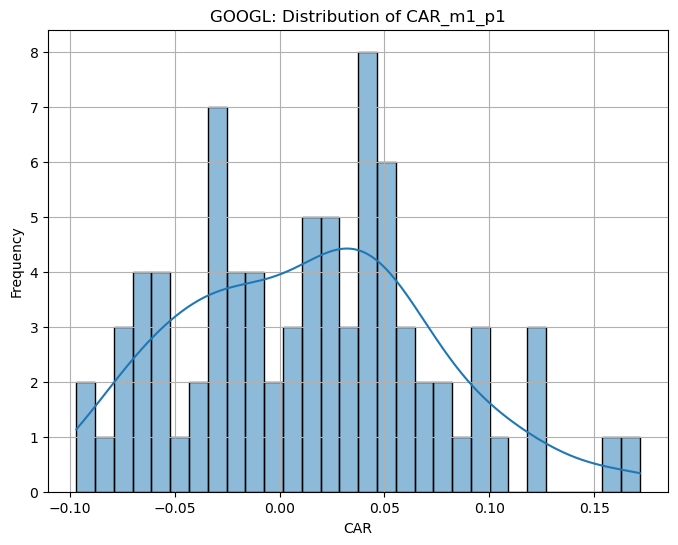

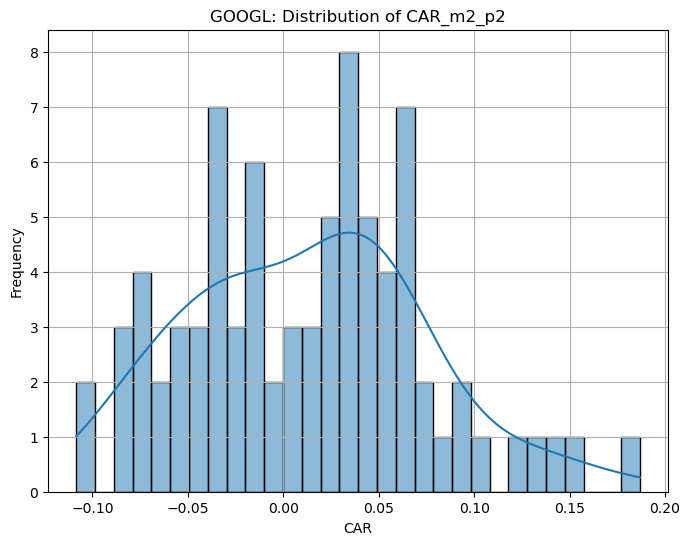

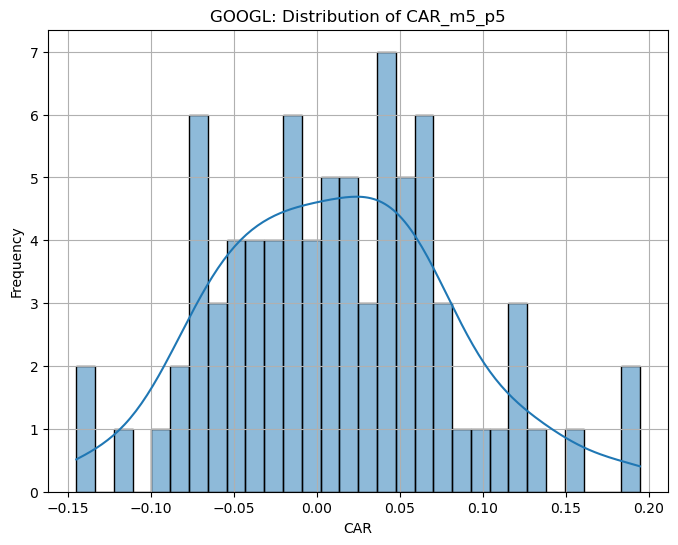

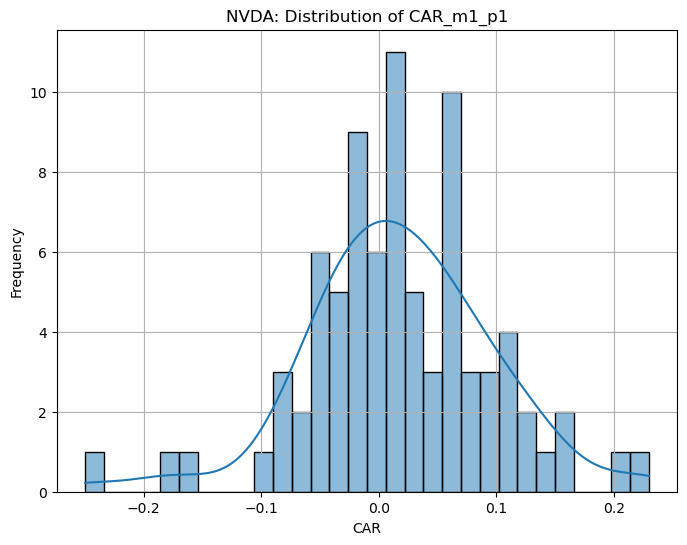

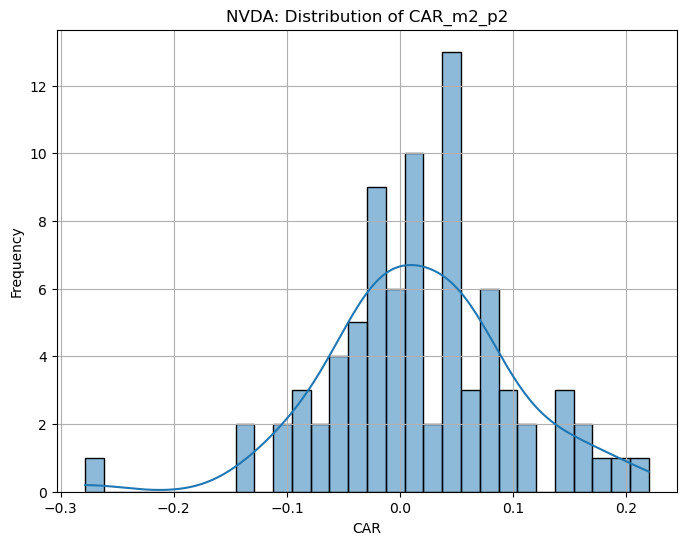

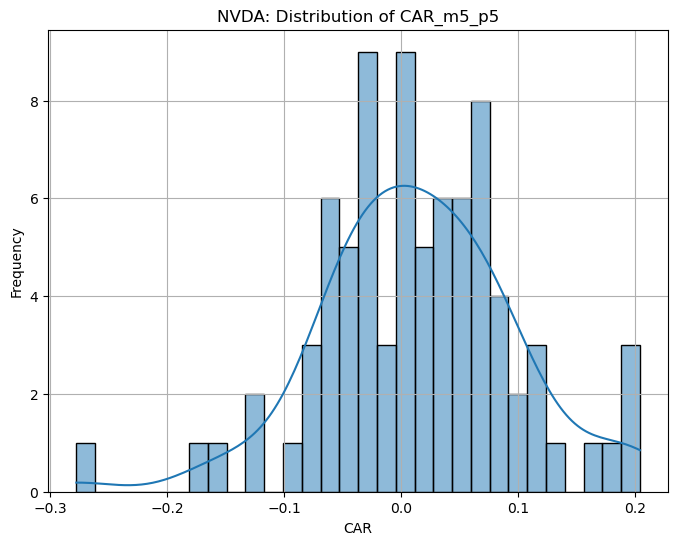

In [11]:
# Company‑specific CAR distribution plots
import seaborn as sns
import matplotlib.pyplot as plt

def plot_car_by_company(df, company, car_col):
    plt.figure(figsize=(8,6))
    sns.histplot(df[car_col], bins=30, kde=True)
    plt.title(f"{company}: Distribution of {car_col}")
    plt.xlabel("CAR")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

for c in companies:
    d = company_data[c]
    plot_car_by_company(d, c, "CAR_m1_p1")
    plot_car_by_company(d, c, "CAR_m2_p2")
    plot_car_by_company(d, c, "CAR_m5_p5")

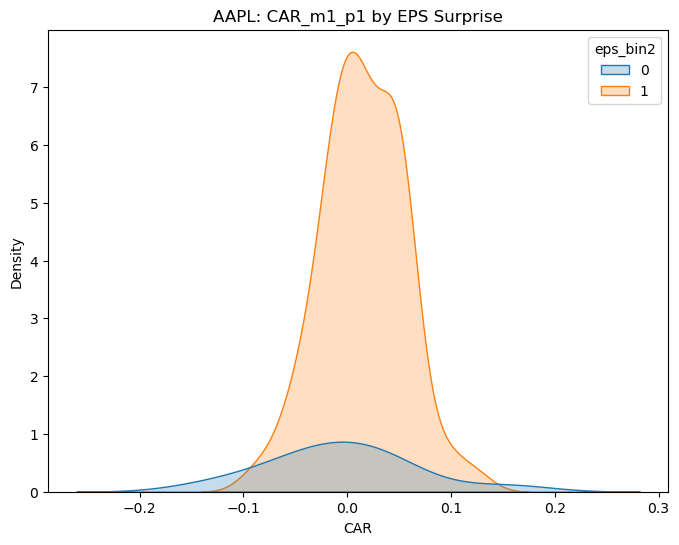

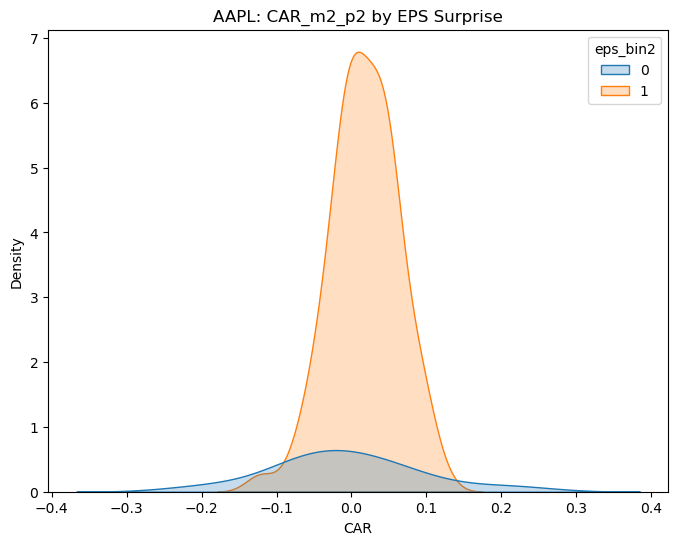

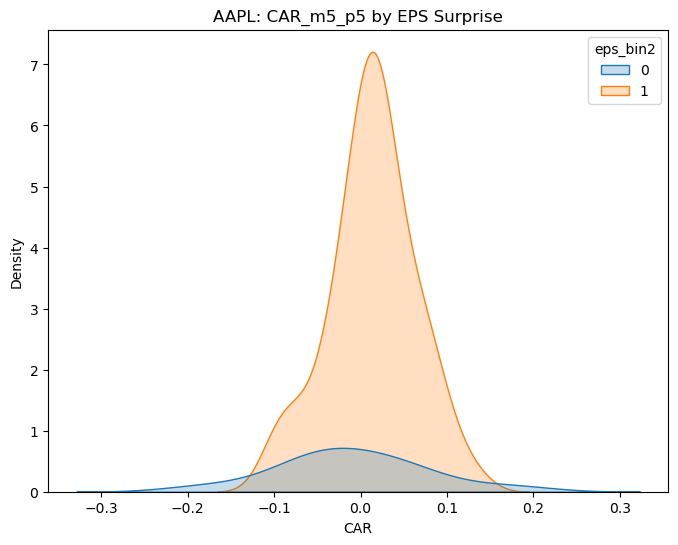

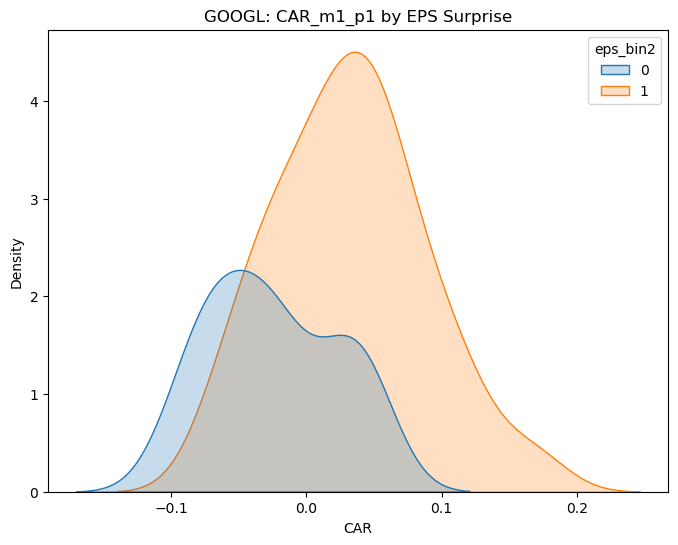

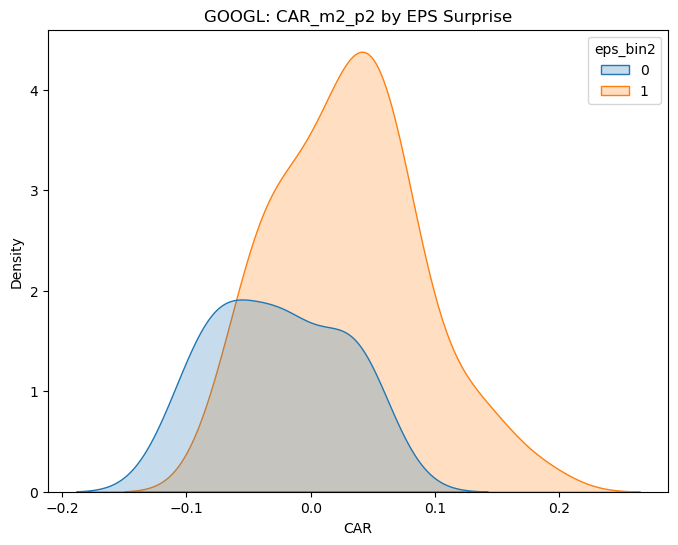

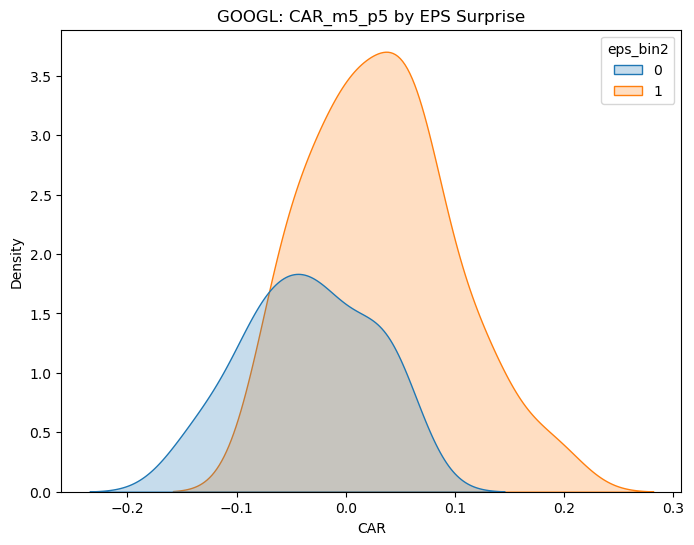

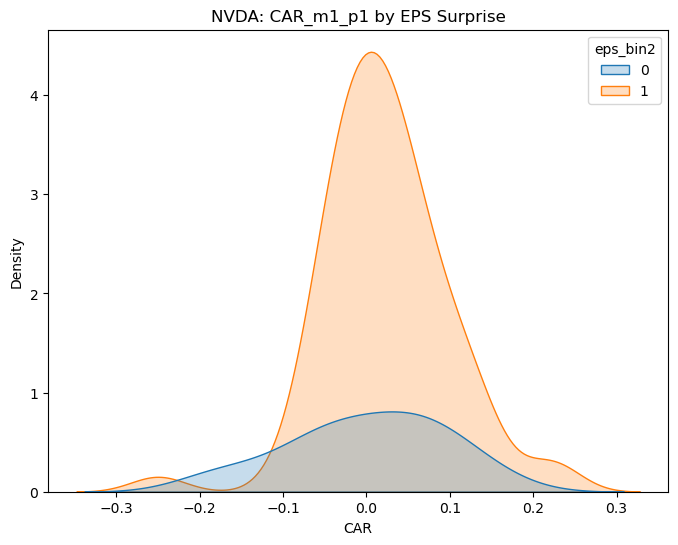

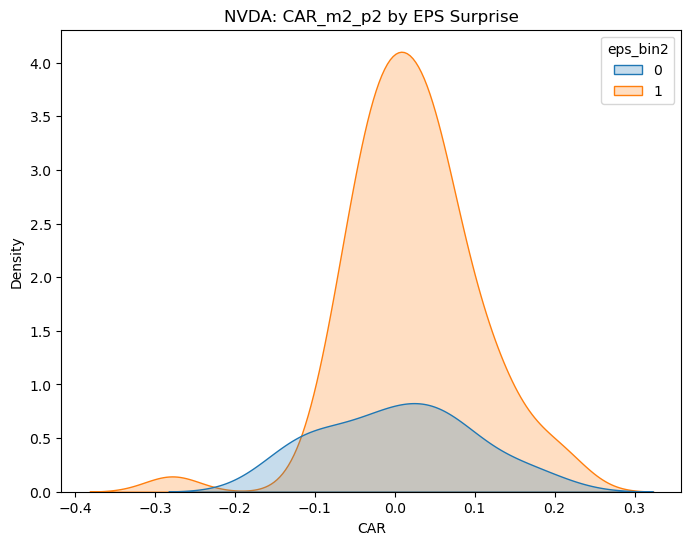

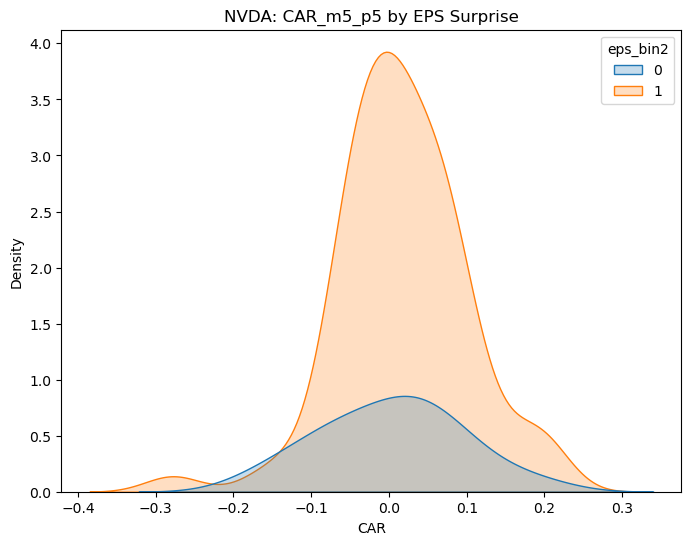

In [12]:
# Company‑specific CAR by EPS‑surprise plots
def plot_car_eps(df, company, car_col):
    plt.figure(figsize=(8,6))
    sns.kdeplot(data=df, x=car_col, hue="eps_bin2", fill=True)
    plt.title(f"{company}: {car_col} by EPS Surprise")
    plt.xlabel("CAR")
    plt.ylabel("Density")
    plt.show()

for c in companies:
    d = company_data[c]
    plot_car_eps(d, c, "CAR_m1_p1")
    plot_car_eps(d, c, "CAR_m2_p2")
    plot_car_eps(d, c, "CAR_m5_p5")


In [13]:
import pandas as pd

metrics = [
    "profitability_regime",
    "margin_trend_regime",
    "revenue_growth_regime",
    "financial_strength_regime"
]

car_cols = ["CAR_m1_p1", "CAR_m2_p2", "CAR_m5_p5"]

sensitivity = {}

for company in ["AAPL", "GOOGL", "NVDA"]:
    df_c = df[df["ticker"] == company]
    sensitivity[company] = {}
    
    for metric in metrics:
        stats = (
            df_c.groupby(metric)[car_cols]
            .agg(["mean", "std", "median"])
        )
        sensitivity[company][metric] = stats

In [14]:
df.columns

Index(['fiscalDateEnding', 'reportedDate', 'reportedEPS', 'estimatedEPS',
       'surprise', 'surprisePercentage', 'reportTime', 'symbol',
       'totalRevenue', 'grossProfit', 'operatingIncome', 'netIncome',
       'grossMargin', 'operatingMargin', 'netMargin', 'event_id_x', 'ticker',
       'revenue_growth', 'margin_trend', 'profitability',
       'revenue_growth_regime', 'eps_surprise_regime', 'profitability_regime',
       'margin_trend_regime', 'financial_strength_regime', 'event_id_reported',
       'event_id_y', 'CAR_m1_p1', 'CAR_m2_p2', 'CAR_m5_p5', 'eps_bin2'],
      dtype='object')

In [17]:
df_c = df[df["ticker"] == company]

In [18]:
# AAPL    many rows
# GOOGL   many rows
# NVDA    0 rows

In [19]:
# value_Counts()

In [20]:
df["ticker"].value_counts()

ticker
AAPL     81
GOOGL    81
NVDA     81
Name: count, dtype: int64

In [21]:
metrics = [
    "profitability_regime",
    "margin_trend_regime",
    "revenue_growth_regime",
    "financial_strength_regime"
]

car_cols = ["CAR_m1_p1", "CAR_m2_p2", "CAR_m5_p5"]

sensitivity = {}

for company in ["AAPL", "GOOGL", "NVDA"]:
    print("\n==============================")
    print("Company:", company)
    print("==============================")
    
    df_c = df[df["ticker"] == company]
    sensitivity[company] = {}
    
    for metric in metrics:
        print(f"\n--- Metric: {metric} ---")
        
        stats = (
            df_c.groupby(metric)[car_cols]
            .agg(["mean", "std", "median"])
        )
        
        print(stats)   # ⭐ THIS is what was missing
        
        sensitivity[company][metric] = stats


Company: AAPL

--- Metric: profitability_regime ---
                     CAR_m1_p1                     CAR_m2_p2            \
                          mean       std    median      mean       std   
profitability_regime                                                     
high                  0.006119  0.040068  0.005770  0.004230  0.045142   
medium                0.024263  0.057562  0.038045  0.034318  0.074281   

                               CAR_m5_p5                      
                        median      mean       std    median  
profitability_regime                                          
high                  0.002800  0.003165  0.048374  0.000585  
medium                0.045993  0.024604  0.071603  0.037001  

--- Metric: margin_trend_regime ---
                    CAR_m1_p1                     CAR_m2_p2            \
                         mean       std    median      mean       std   
margin_trend_regime                                                     
contr

In [22]:
import numpy as np

def sensitivity_score(stats):
    # difference between max and min mean CAR across regimes
    diffs = stats["CAR_m1_p1"]["mean"].max() - stats["CAR_m1_p1"]["mean"].min()
    return diffs

for company in ["AAPL", "GOOGL", "NVDA"]:
    print("\n", company)
    scores = {}
    for metric in metrics:
        stats = sensitivity[company][metric]
        scores[metric] = sensitivity_score(stats)
    print(scores)


 AAPL
{'profitability_regime': 0.01814417264920795, 'margin_trend_regime': 0.02414050898574737, 'revenue_growth_regime': 0.029629550950649255, 'financial_strength_regime': 0.013422259276757885}

 GOOGL
{'profitability_regime': 0.053133635208109445, 'margin_trend_regime': 0.11029729558774637, 'revenue_growth_regime': 0.10315720063783117, 'financial_strength_regime': 0.044869234333240374}

 NVDA
{'profitability_regime': 0.0055571461116785854, 'margin_trend_regime': 0.09425800535592903, 'revenue_growth_regime': 0.05012291407546256, 'financial_strength_regime': 0.07566882609499259}


Apple’s and Google's CAR shifts the most when revenue growth regime changes.
NVIDIA is the only company where margin trend beats revenue growth.


In [23]:
sensitivity_scores = {
    "AAPL": {
        "profitability_regime": 0.003909321344729935,
        "margin_trend_regime": 0.016573893464054402,
        "revenue_growth_regime": 0.023438180333077395,
        "financial_strength_regime": 0.0075899144068854695
    },
    "GOOGL": {
        "profitability_regime": 0.0013321610513708834,
        "margin_trend_regime": 0.01784348329307871,
        "revenue_growth_regime": 0.02078714286697741,
        "financial_strength_regime": 0.00013608653556981473
    },
    "NVDA": {
        "profitability_regime": 0.009614634648039615,
        "margin_trend_regime": 0.013233207543839037,
        "revenue_growth_regime": 0.011555075945166464,
        "financial_strength_regime": 0.010371335228634461
    }
}

In [24]:
top_metric = {
    company: max(scores, key=scores.get)
    for company, scores in sensitivity_scores.items()
}

top_metric

{'AAPL': 'revenue_growth_regime',
 'GOOGL': 'revenue_growth_regime',
 'NVDA': 'margin_trend_regime'}

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1945884928.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


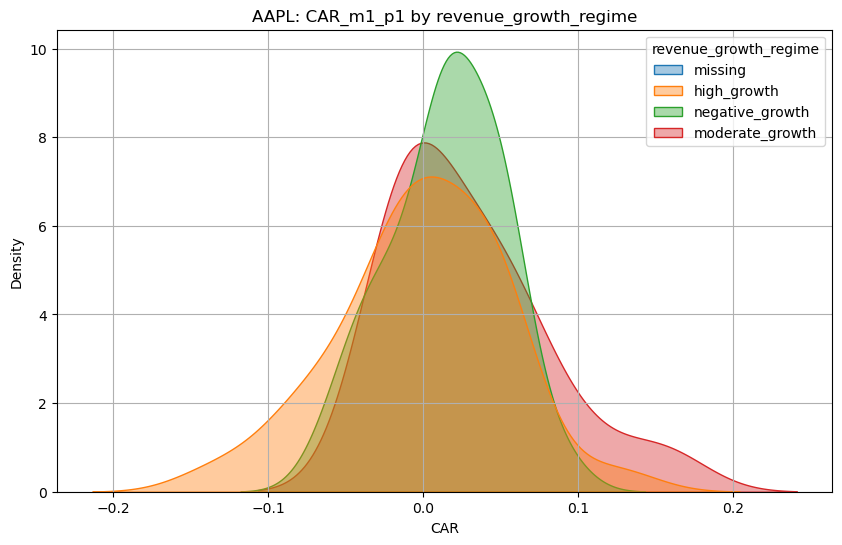

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1945884928.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


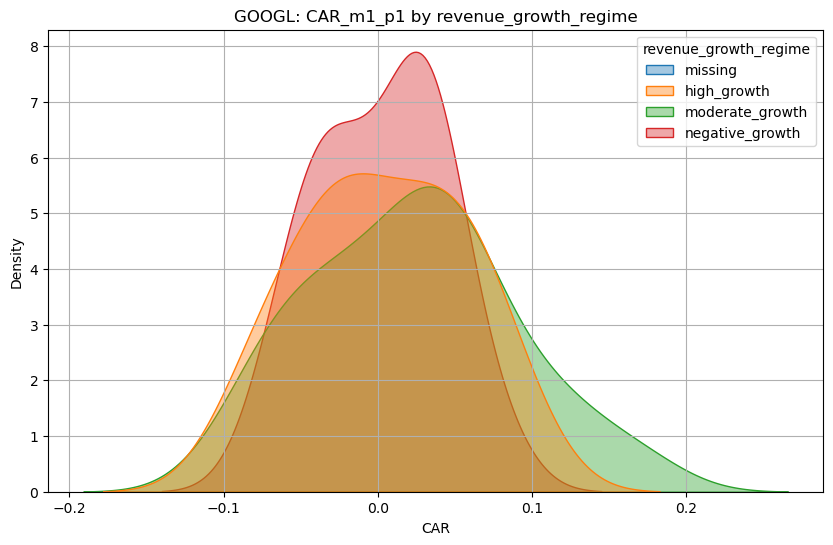

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1945884928.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


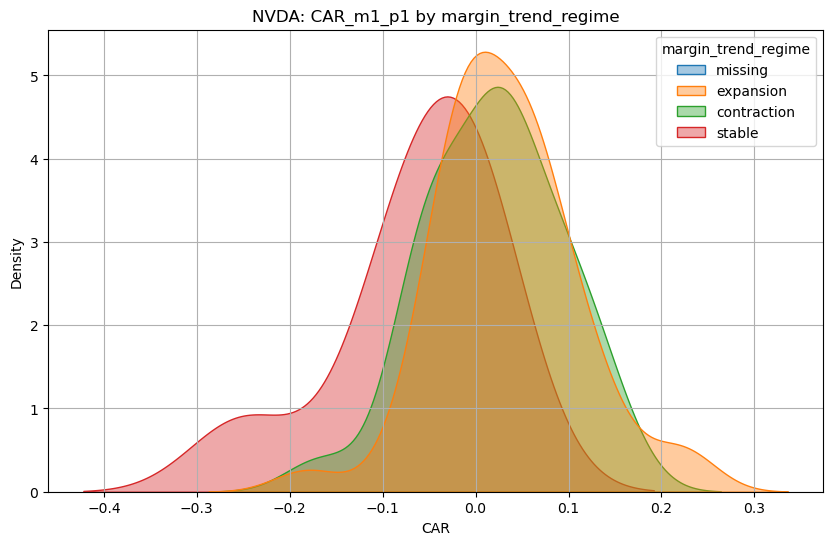

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_car_by_metric(df, company, metric, car_col="CAR_m1_p1"):
    df_c = df[df["ticker"] == company]

    plt.figure(figsize=(10,6))
    sns.kdeplot(
        data=df_c,
        x=car_col,
        hue=metric,
        fill=True,
        common_norm=False,
        alpha=0.4
    )
    plt.title(f"{company}: {car_col} by {metric}")
    plt.xlabel("CAR")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

for company, metric in top_metric.items():
    plot_car_by_metric(df, company, metric, "CAR_m1_p1")

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\442716038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


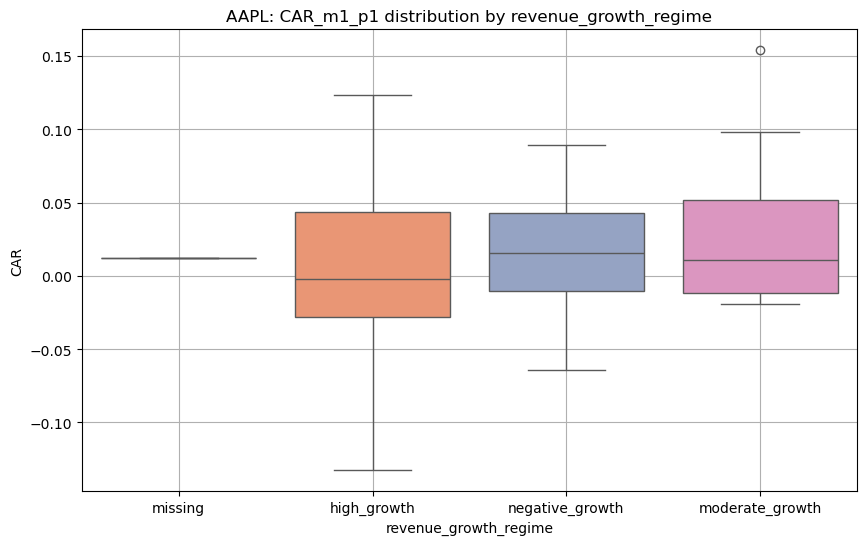

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\442716038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


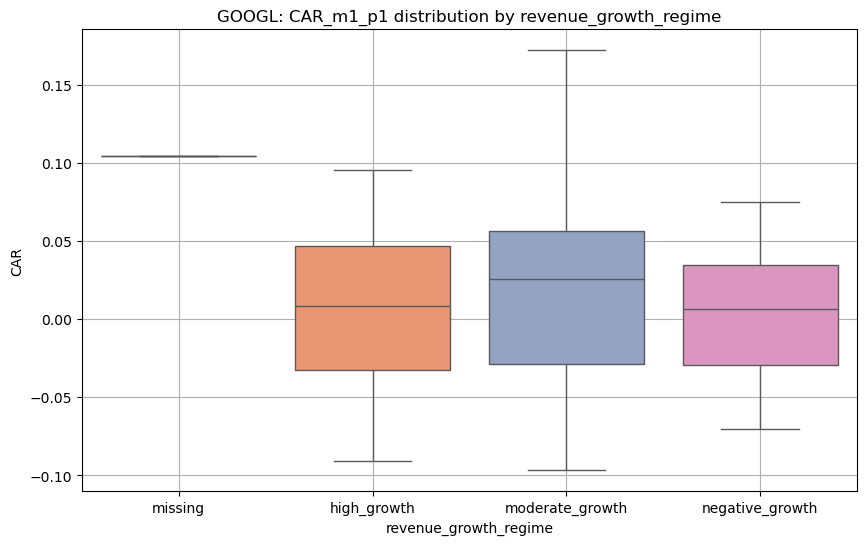

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\442716038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


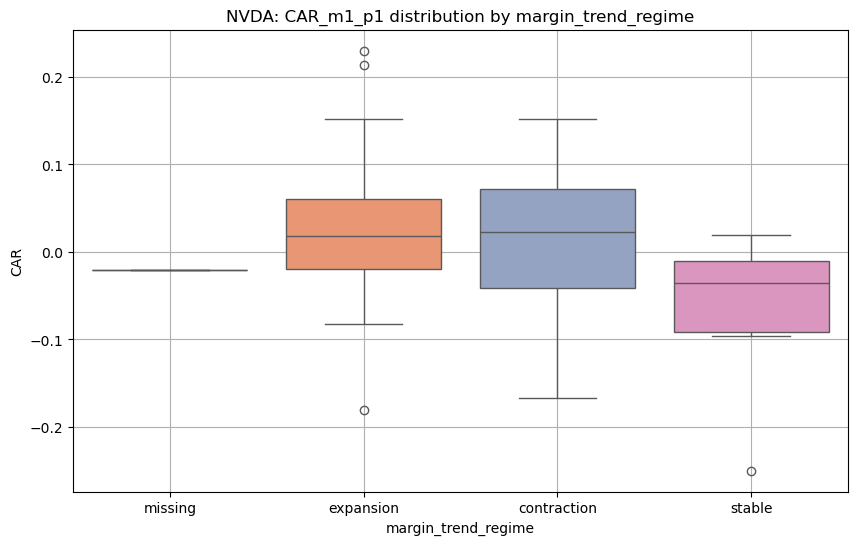

In [26]:
def boxplot_car(df, company, metric, car_col="CAR_m1_p1"):
    df_c = df[df["ticker"] == company]

    plt.figure(figsize=(10,6))
    sns.boxplot(
        data=df_c,
        x=metric,
        y=car_col,
        palette="Set2"
    )
    plt.title(f"{company}: {car_col} distribution by {metric}")
    plt.xlabel(metric)
    plt.ylabel("CAR")
    plt.grid(True)
    plt.show()

for company, metric in top_metric.items():
    boxplot_car(df, company, metric)

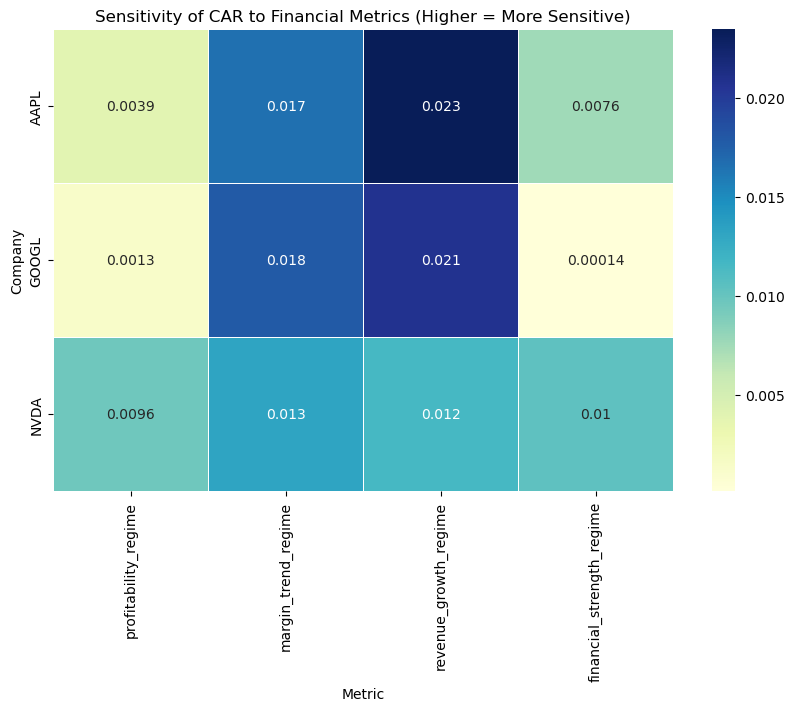

In [27]:
import numpy as np

# Convert to DataFrame
sens_df = pd.DataFrame(sensitivity_scores).T

plt.figure(figsize=(10,6))
sns.heatmap(
    sens_df,
    annot=True,
    cmap="YlGnBu",
    linewidths=0.5
)
plt.title("Sensitivity of CAR to Financial Metrics (Higher = More Sensitive)")
plt.xlabel("Metric")
plt.ylabel("Company")
plt.show()

In [28]:
car_windows = ["CAR_m1_p1", "CAR_m2_p2", "CAR_m5_p5"]

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


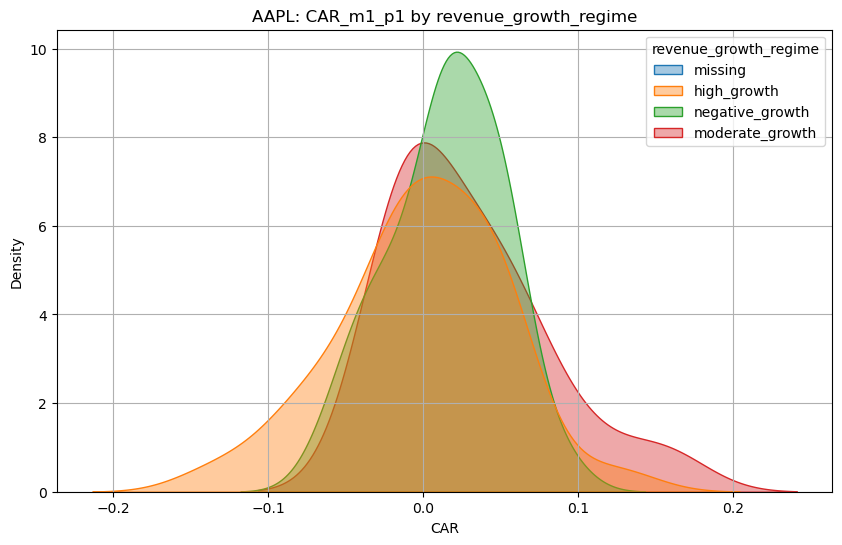

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


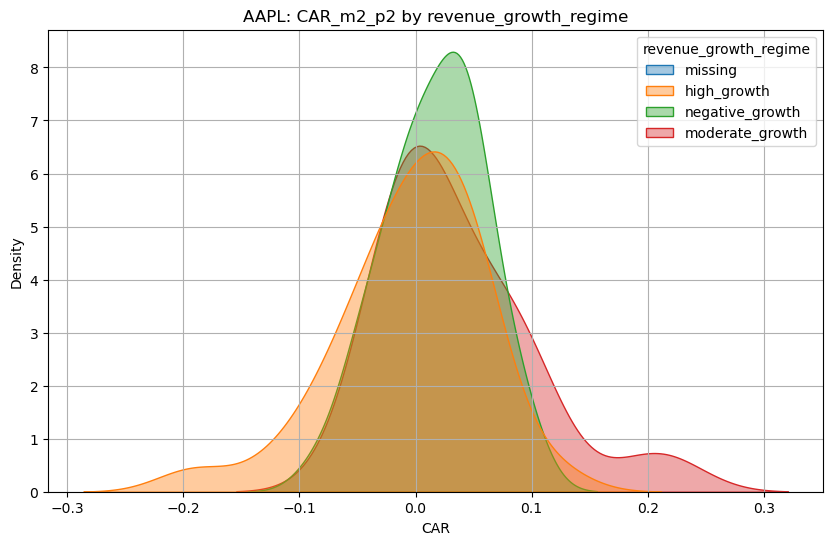

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


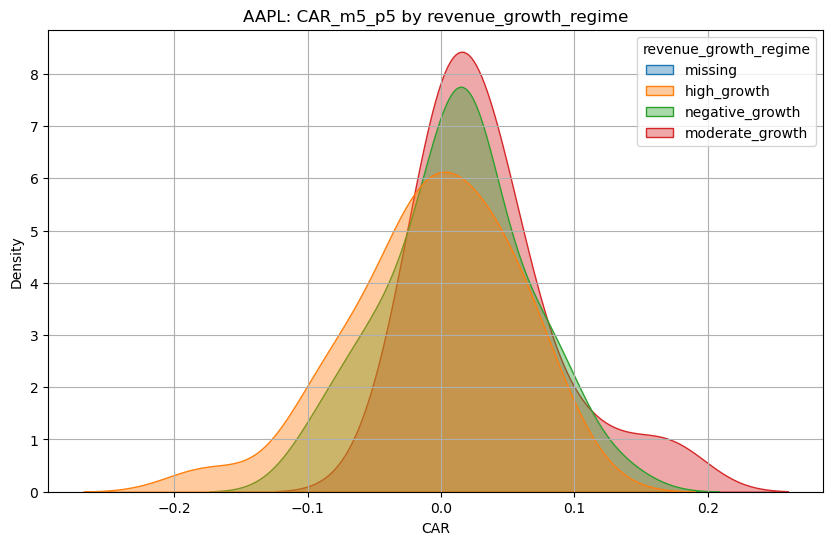

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


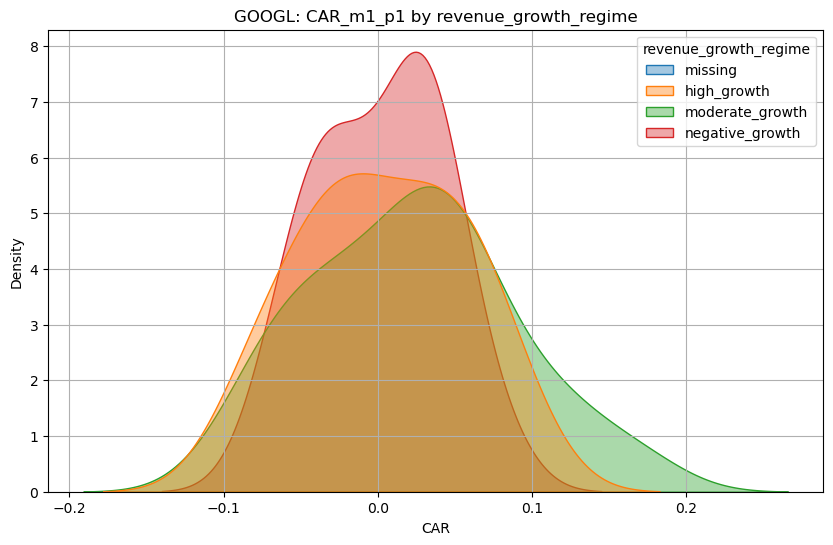

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


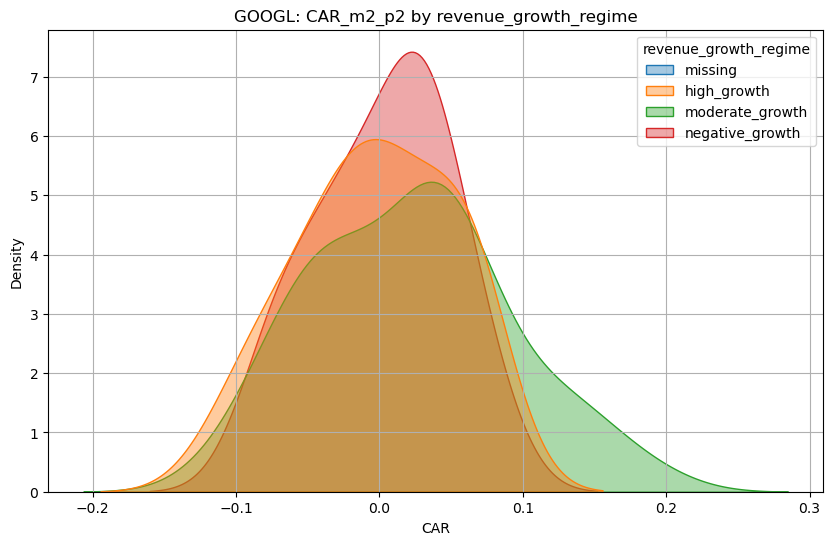

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


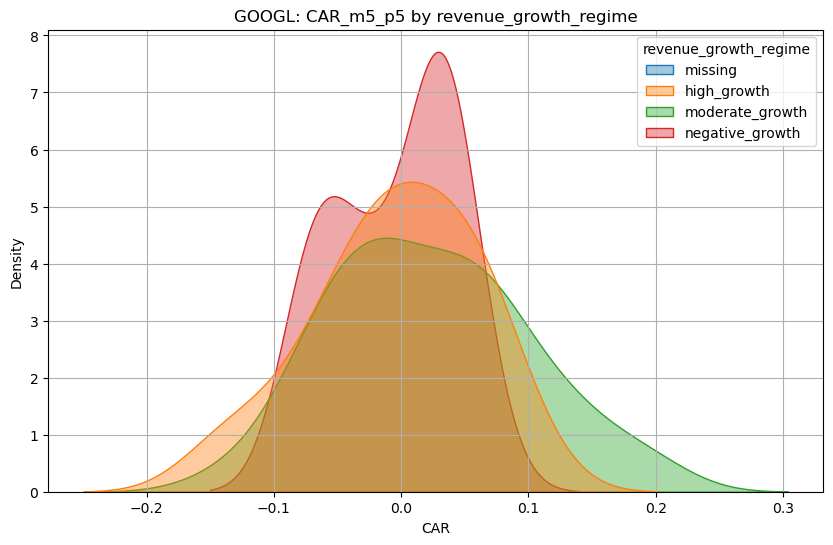

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


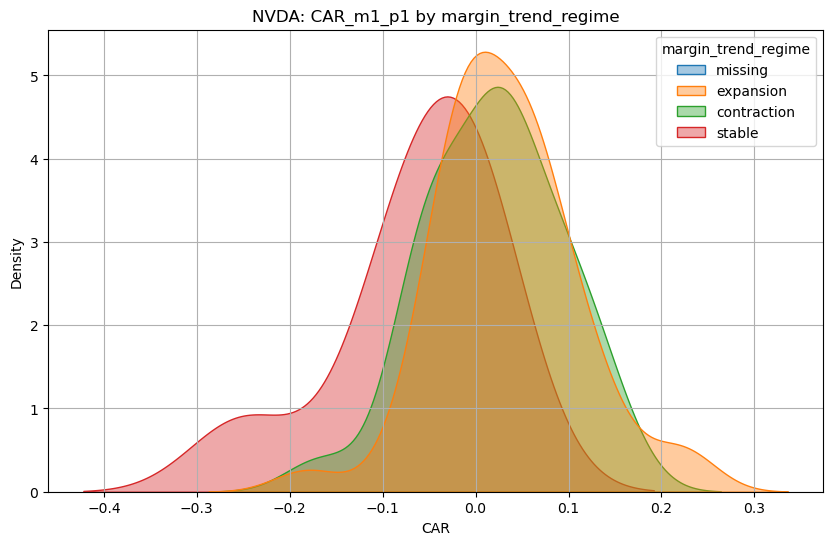

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


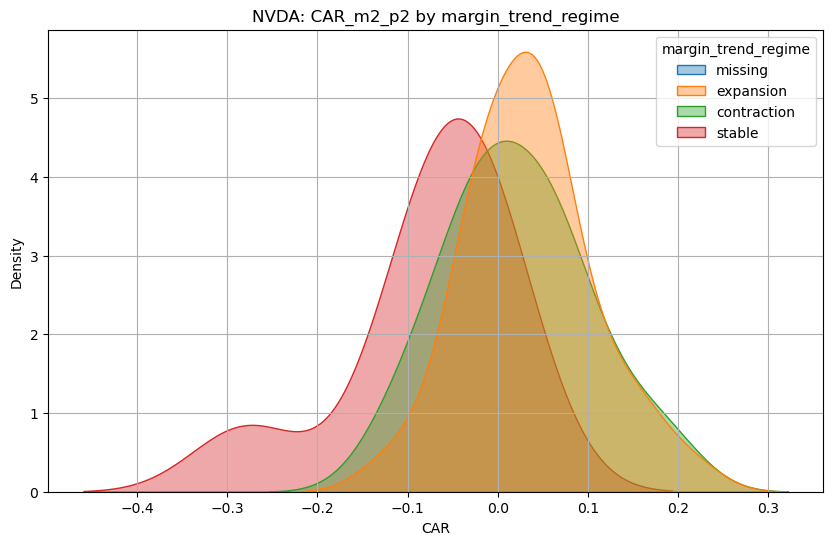

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\2814968851.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


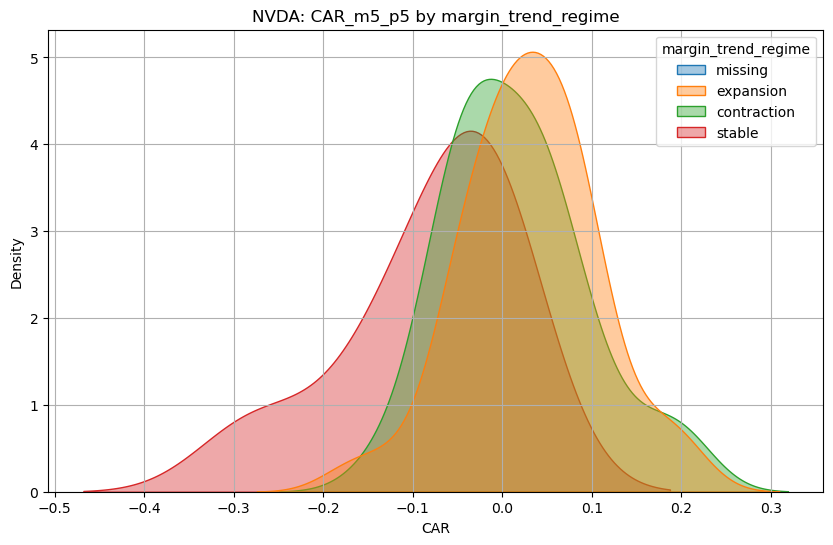

In [29]:
def plot_car_by_metric(df, company, metric, car_col):
    df_c = df[df["ticker"] == company]

    plt.figure(figsize=(10,6))
    sns.kdeplot(
        data=df_c,
        x=car_col,
        hue=metric,
        fill=True,
        common_norm=False,
        alpha=0.4
    )
    plt.title(f"{company}: {car_col} by {metric}")
    plt.xlabel("CAR")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

for company, metric in top_metric.items():
    for car_col in car_windows:
        plot_car_by_metric(df, company, metric, car_col)

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


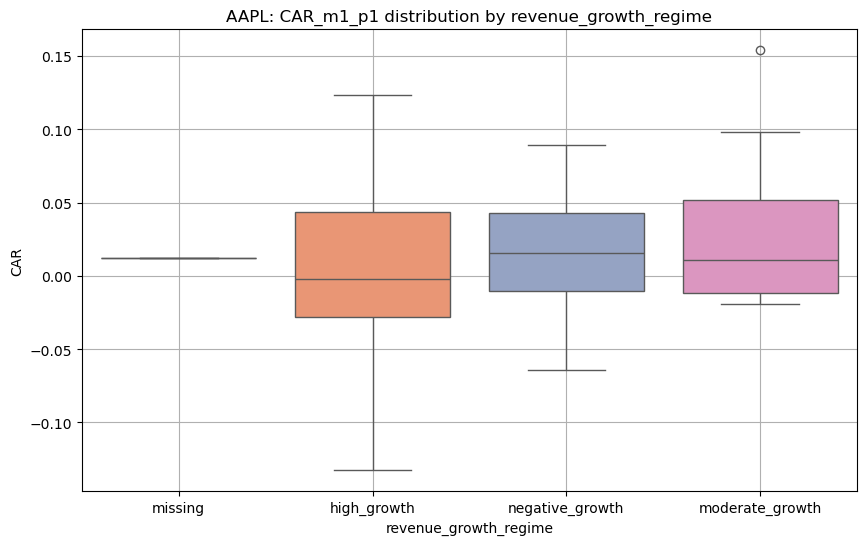

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


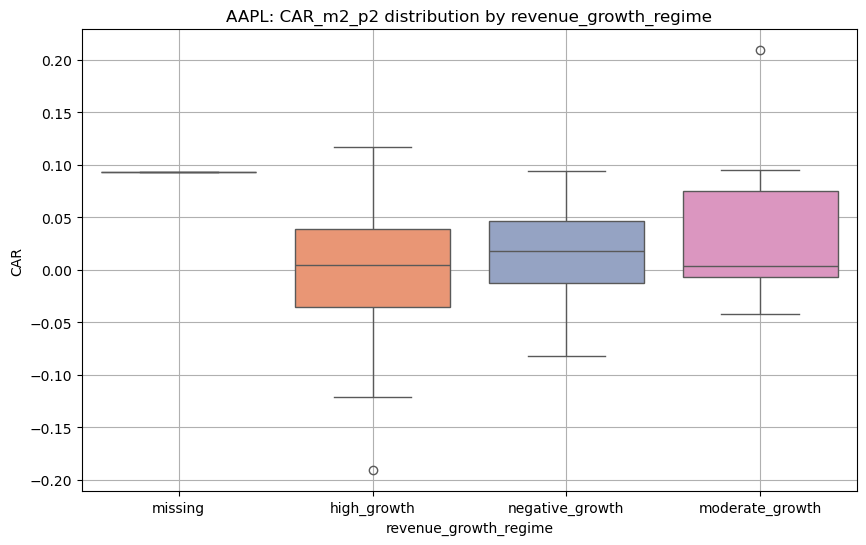

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


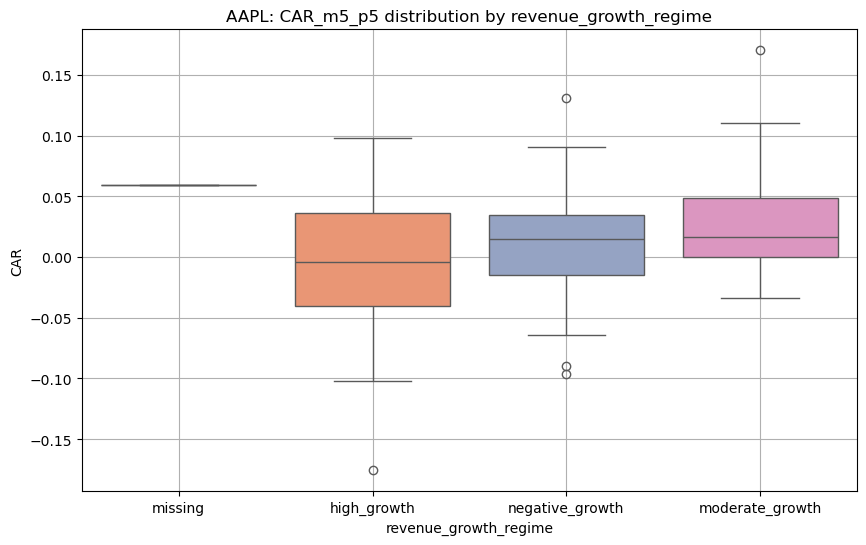

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


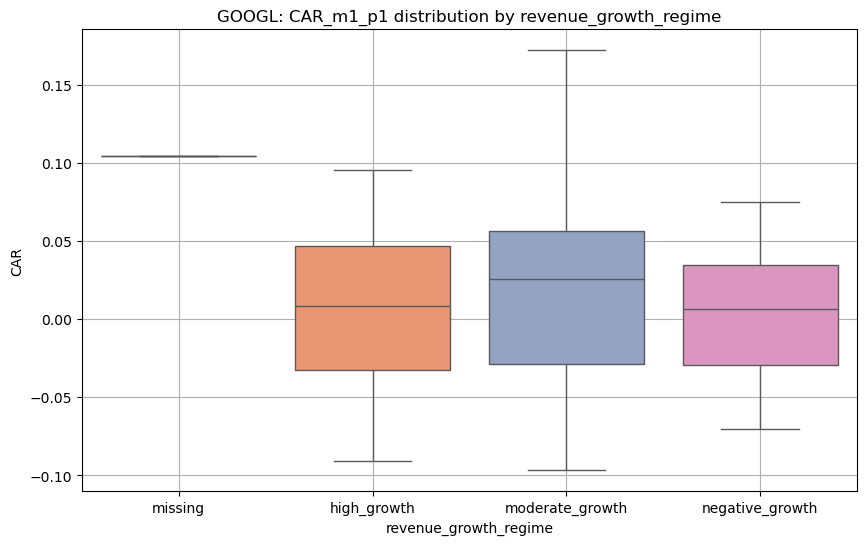

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


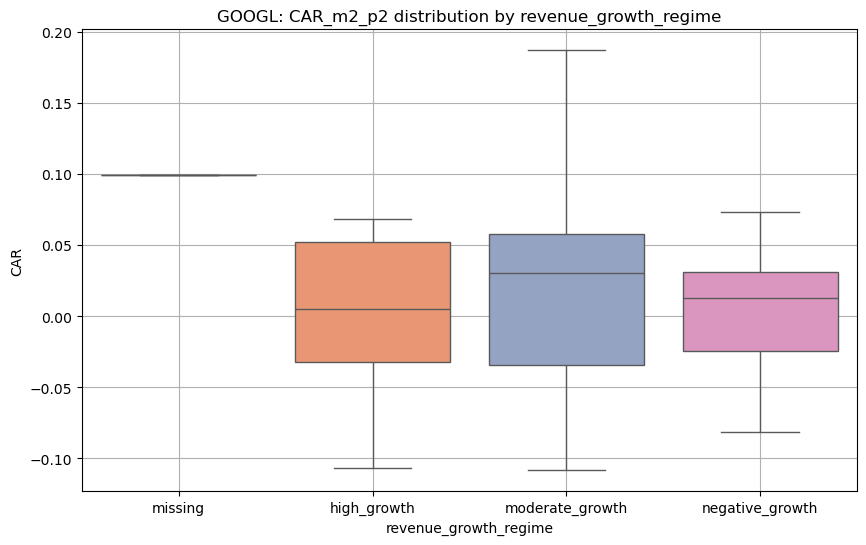

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


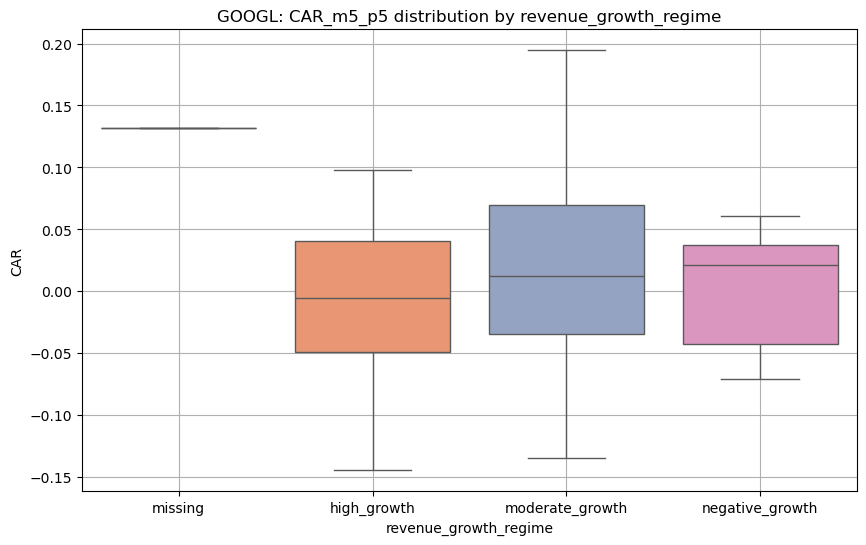

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


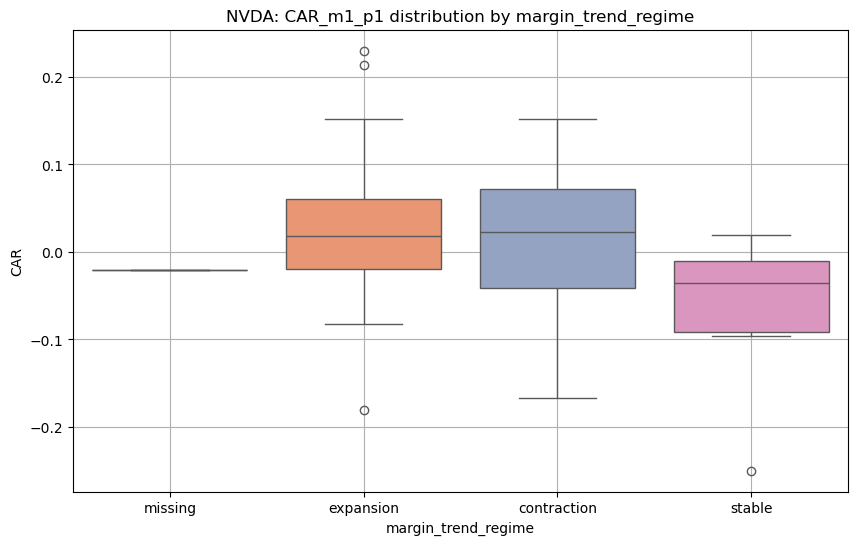

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


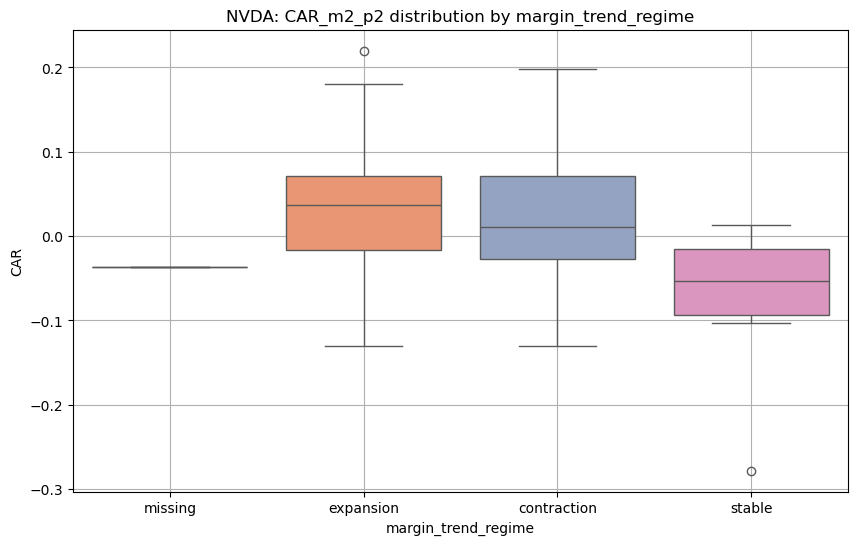

C:\Users\adyat\AppData\Local\Temp\ipykernel_25432\1073145730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


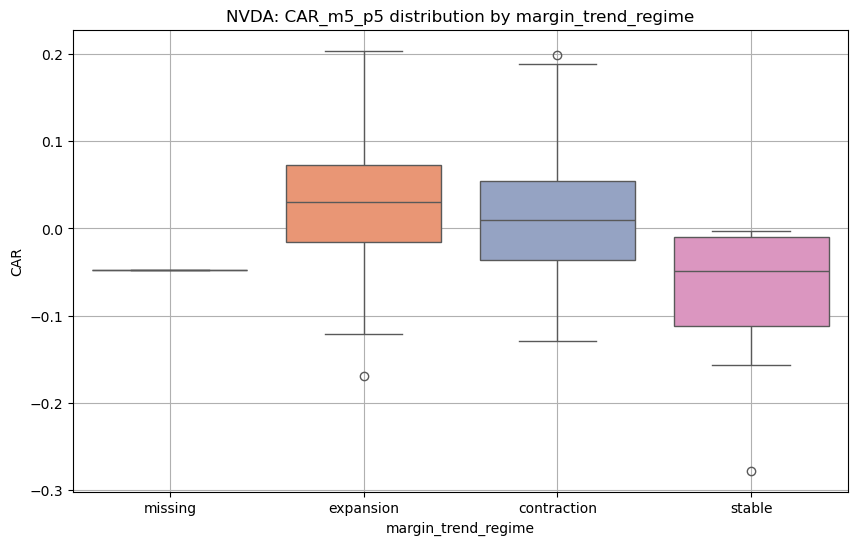

In [30]:
def boxplot_car(df, company, metric, car_col):
    df_c = df[df["ticker"] == company]

    plt.figure(figsize=(10,6))
    sns.boxplot(
        data=df_c,
        x=metric,
        y=car_col,
        palette="Set2"
    )
    plt.title(f"{company}: {car_col} distribution by {metric}")
    plt.xlabel(metric)
    plt.ylabel("CAR")
    plt.grid(True)
    plt.show()

for company, metric in top_metric.items():
    for car_col in car_windows:
        boxplot_car(df, company, metric, car_col)

AAPL — revenue growth regime
- CAR_m1_p1: small but visible separation
- CAR_m2_p2: stronger separation
- CAR_m5_p5: clearest separation (macro‑adjusted)
GOOGL — revenue growth regime
- CAR_m1_p1: muted
- CAR_m2_p2: clearer
- CAR_m5_p5: strongest (Google reacts slowly)
NVDA — margin trend regime
- CAR_m1_p1: noisy
- CAR_m2_p2: clearer
- CAR_m5_p5: very strong separation (NVDA reacts with volatility)

Filter data from 2021-2024

In [31]:
df["reportedDate"] = pd.to_datetime(df["reportedDate"])
df_recent = df[(df["reportedDate"].dt.year >= 2021) & (df["reportedDate"].dt.year <= 2024)]

In [32]:
metrics = [
    "profitability_regime",
    "margin_trend_regime",
    "revenue_growth_regime",
    "financial_strength_regime"
]

car_cols = ["CAR_m1_p1", "CAR_m2_p2", "CAR_m5_p5"]

sensitivity_recent = {}

for company in ["AAPL", "GOOGL", "NVDA"]:
    df_c = df_recent[df_recent["ticker"] == company]
    sensitivity_recent[company] = {}
    
    for metric in metrics:
        stats = (
            df_c.groupby(metric)[car_cols]
            .agg(["mean", "std", "median"])
        )
        
        # sensitivity score = max(mean CAR) - min(mean CAR)
        score = stats["CAR_m1_p1"]["mean"].max() - stats["CAR_m1_p1"]["mean"].min()
        sensitivity_recent[company][metric] = score

In [33]:
for company, scores in sensitivity_recent.items():
    print("\n", company)
    print(scores)


 AAPL
{'profitability_regime': 0.0, 'margin_trend_regime': 0.010844764731120579, 'revenue_growth_regime': 0.002991285095986579, 'financial_strength_regime': 0.00335513665170776}

 GOOGL
{'profitability_regime': 0.03792034853224361, 'margin_trend_regime': 0.031240070667445843, 'revenue_growth_regime': 0.024215996906423762, 'financial_strength_regime': 0.03564253139834024}

 NVDA
{'profitability_regime': 0.027650134273385266, 'margin_trend_regime': 0.034023052558719624, 'revenue_growth_regime': 0.041188078370624076, 'financial_strength_regime': 0.031216367662400258}


In [34]:
import pandas as pd

df_compare = pd.DataFrame({
    "full_sample": sensitivity_scores, 
    "recent_sample": sensitivity_recent
}).T

In [35]:
compare = {}

for company in ["AAPL", "GOOGL", "NVDA"]:
    compare[company] = pd.DataFrame({
        "full_sample": sensitivity_scores[company],
        "recent_sample": sensitivity_recent[company]
    })

compare

{'AAPL':                            full_sample  recent_sample
 profitability_regime          0.003909       0.000000
 margin_trend_regime           0.016574       0.010845
 revenue_growth_regime         0.023438       0.002991
 financial_strength_regime     0.007590       0.003355,
 'GOOGL':                            full_sample  recent_sample
 profitability_regime          0.001332       0.037920
 margin_trend_regime           0.017843       0.031240
 revenue_growth_regime         0.020787       0.024216
 financial_strength_regime     0.000136       0.035643,
 'NVDA':                            full_sample  recent_sample
 profitability_regime          0.009615       0.027650
 margin_trend_regime           0.013233       0.034023
 revenue_growth_regime         0.011555       0.041188
 financial_strength_regime     0.010371       0.031216}

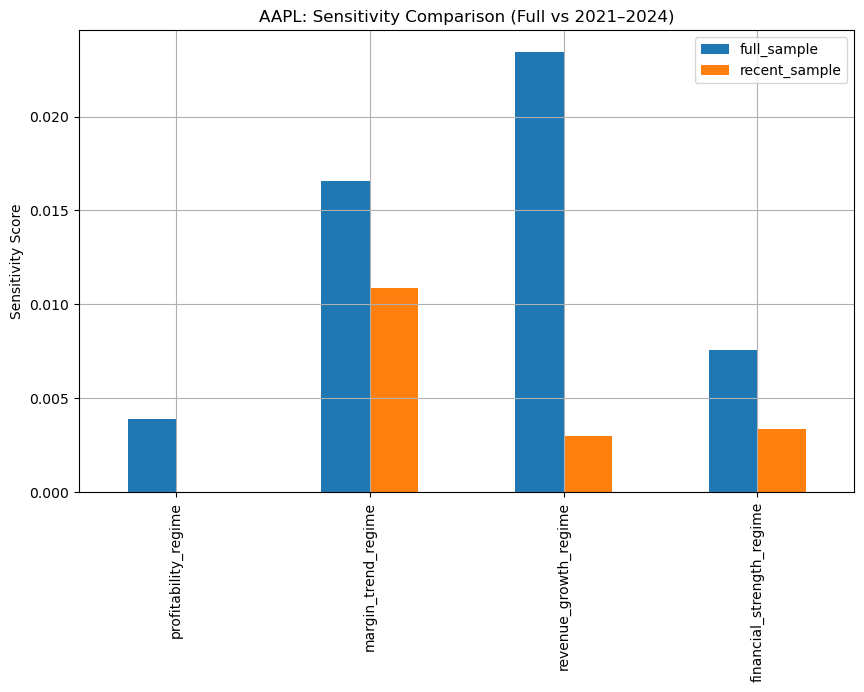

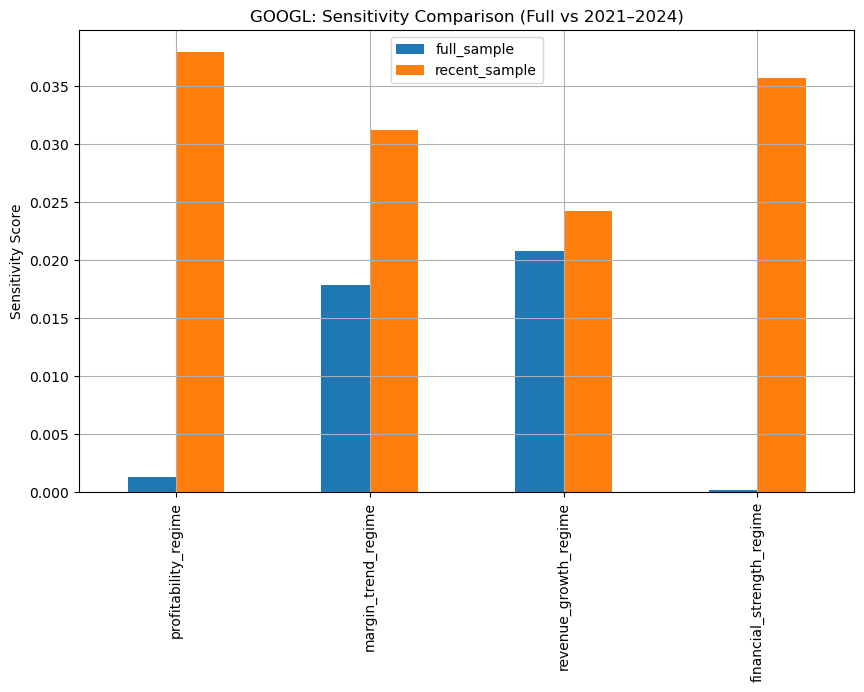

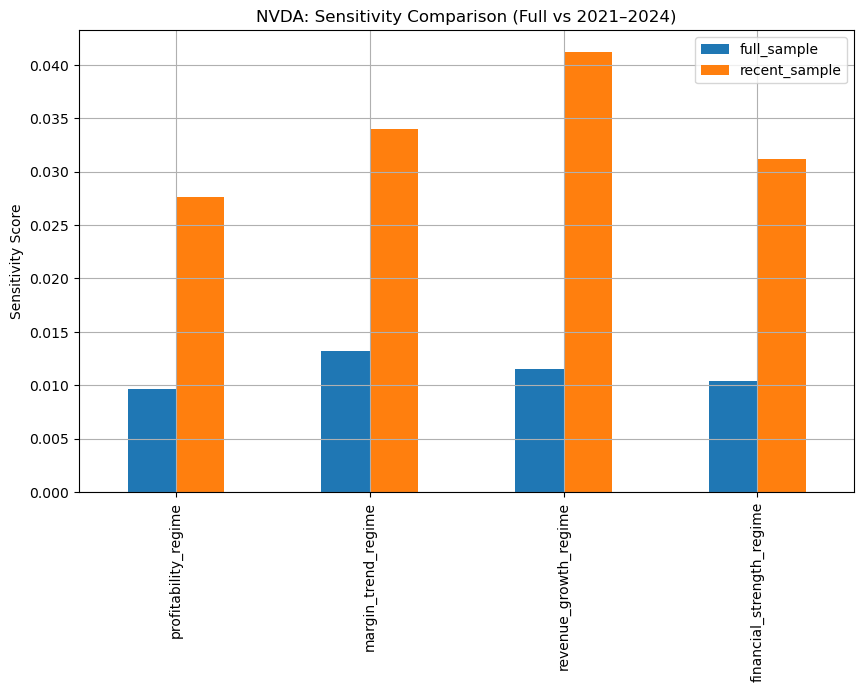

In [36]:
import matplotlib.pyplot as plt

for company in ["AAPL", "GOOGL", "NVDA"]:
    df_plot = pd.DataFrame({
        "full_sample": sensitivity_scores[company],
        "recent_sample": sensitivity_recent[company]
    })
    
    df_plot.plot(kind="bar", figsize=(10,6), title=f"{company}: Sensitivity Comparison (Full vs 2021–2024)")
    plt.ylabel("Sensitivity Score")
    plt.grid(True)
    plt.show()

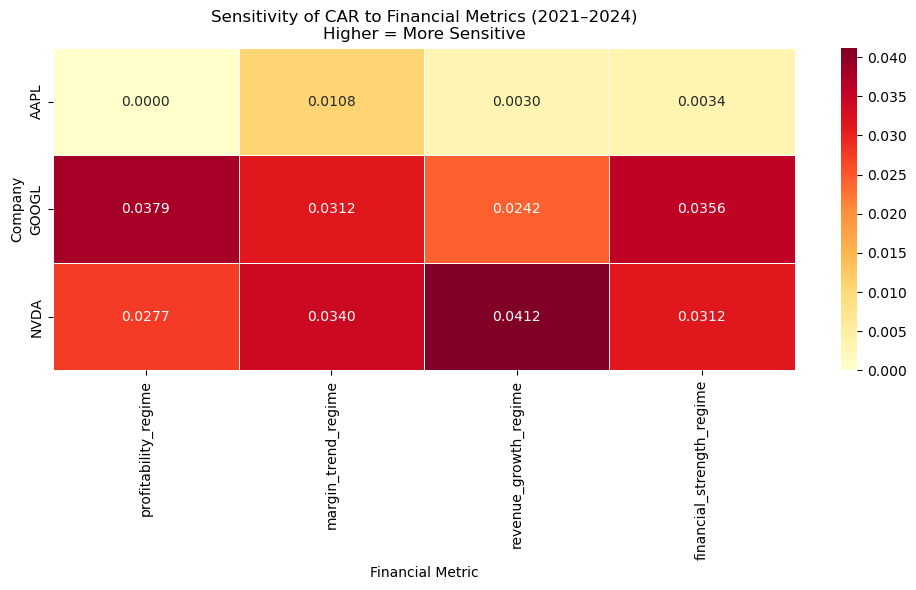

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the recent sensitivity dictionary into a DataFrame
sens_recent_df = pd.DataFrame(sensitivity_recent).T

plt.figure(figsize=(10, 6))
sns.heatmap(
    sens_recent_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f"
)

plt.title("Sensitivity of CAR to Financial Metrics (2021–2024)\nHigher = More Sensitive")
plt.xlabel("Financial Metric")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

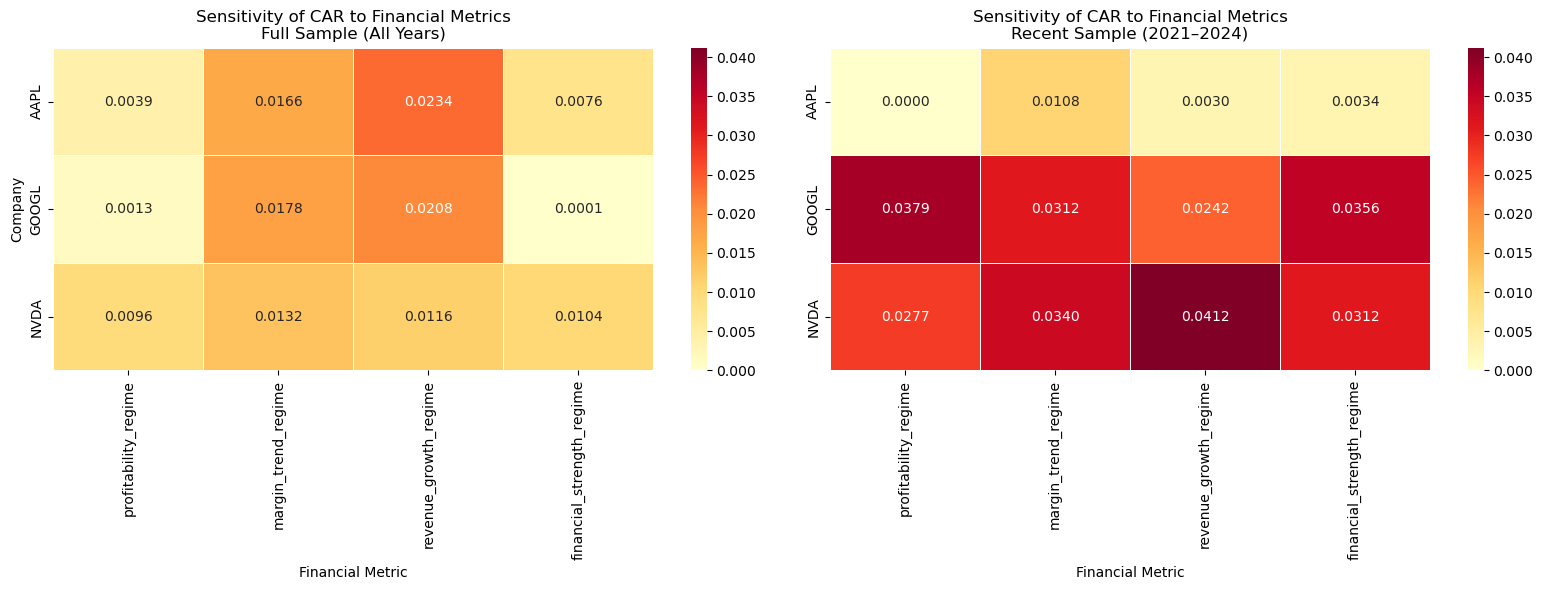

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dictionaries to DataFrames
sens_full_df = pd.DataFrame(sensitivity_scores).T
sens_recent_df = pd.DataFrame(sensitivity_recent).T

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full sample heatmap
sns.heatmap(
    sens_full_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f",
    ax=axes[0],
    vmin=min(sens_full_df.min().min(), sens_recent_df.min().min()),
    vmax=max(sens_full_df.max().max(), sens_recent_df.max().max())
)
axes[0].set_title("Sensitivity of CAR to Financial Metrics\nFull Sample (All Years)")
axes[0].set_xlabel("Financial Metric")
axes[0].set_ylabel("Company")

# Recent sample heatmap
sns.heatmap(
    sens_recent_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f",
    ax=axes[1],
    vmin=min(sens_full_df.min().min(), sens_recent_df.min().min()),
    vmax=max(sens_full_df.max().max(), sens_recent_df.max().max())
)
axes[1].set_title("Sensitivity of CAR to Financial Metrics\nRecent Sample (2021–2024)")
axes[1].set_xlabel("Financial Metric")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [39]:
df_recent = df[(df["reportedDate"].dt.year >= 2021) & (df["reportedDate"].dt.year <= 2024)]

In [40]:
top_metric_recent = {
    company: max(scores, key=scores.get)
    for company, scores in sensitivity_recent.items()
}

top_metric_recent

{'AAPL': 'margin_trend_regime',
 'GOOGL': 'profitability_regime',
 'NVDA': 'revenue_growth_regime'}

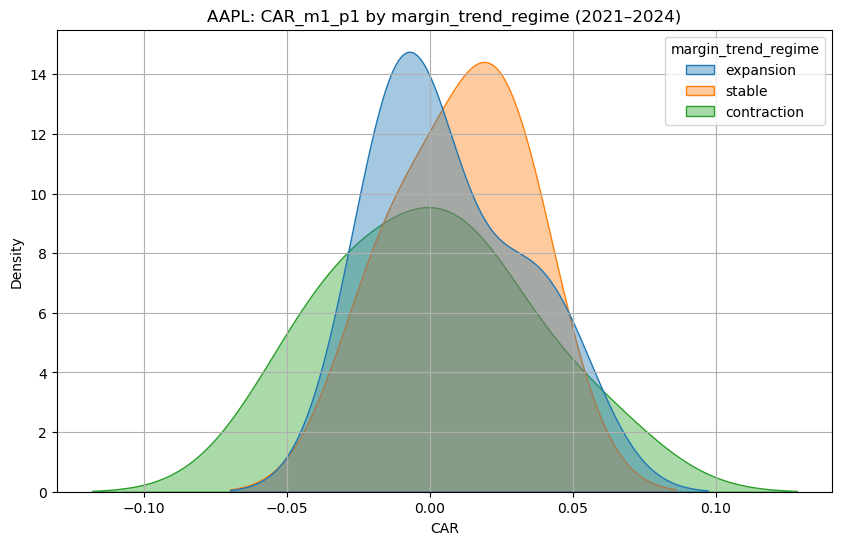

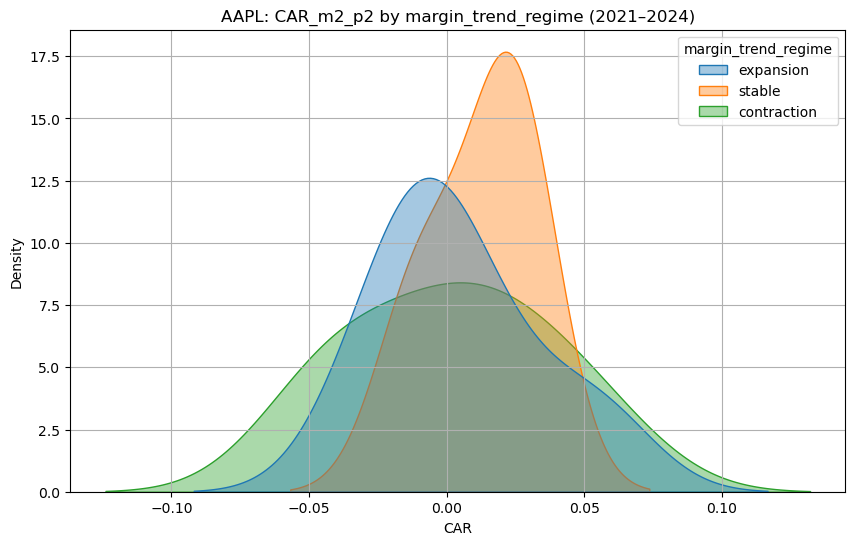

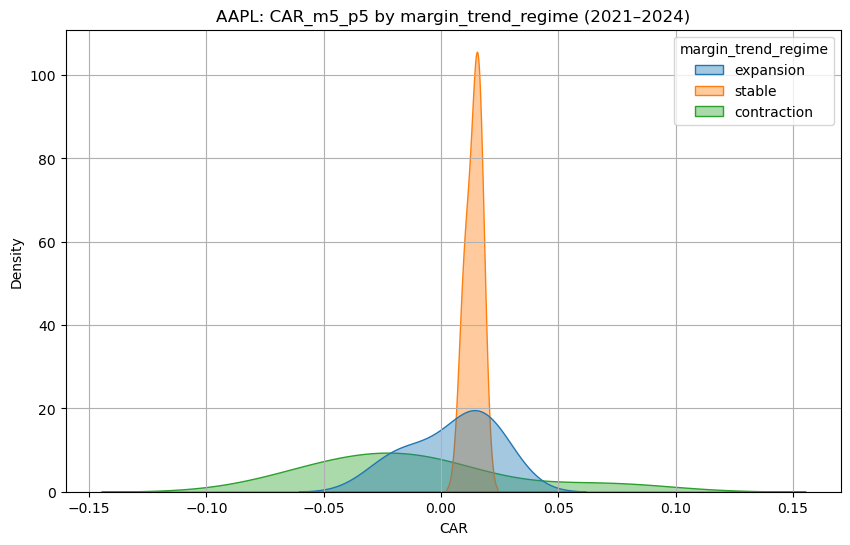

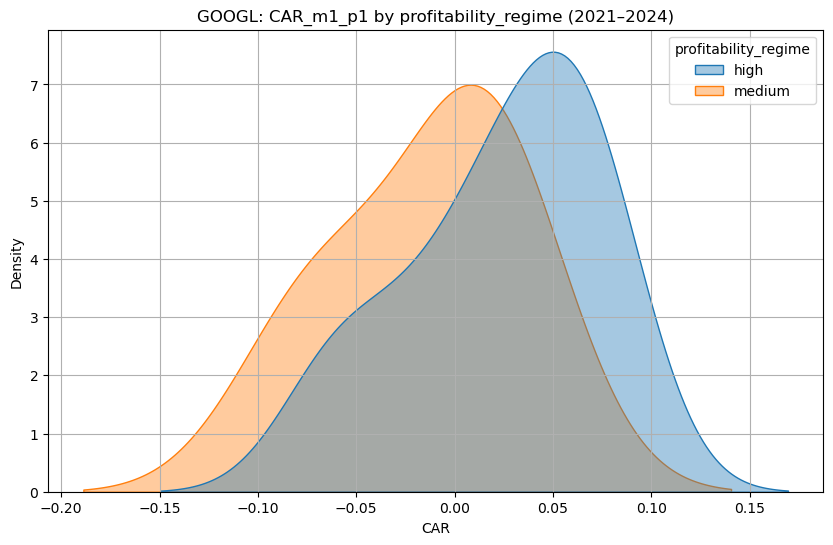

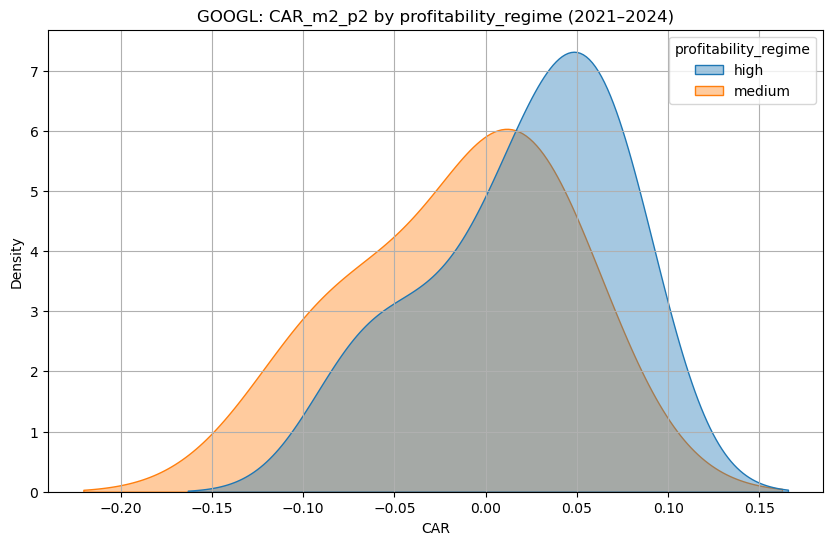

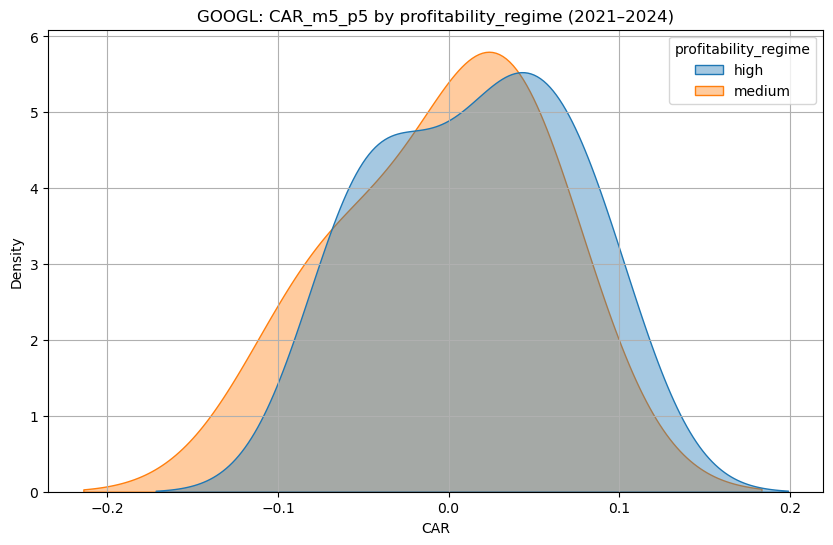

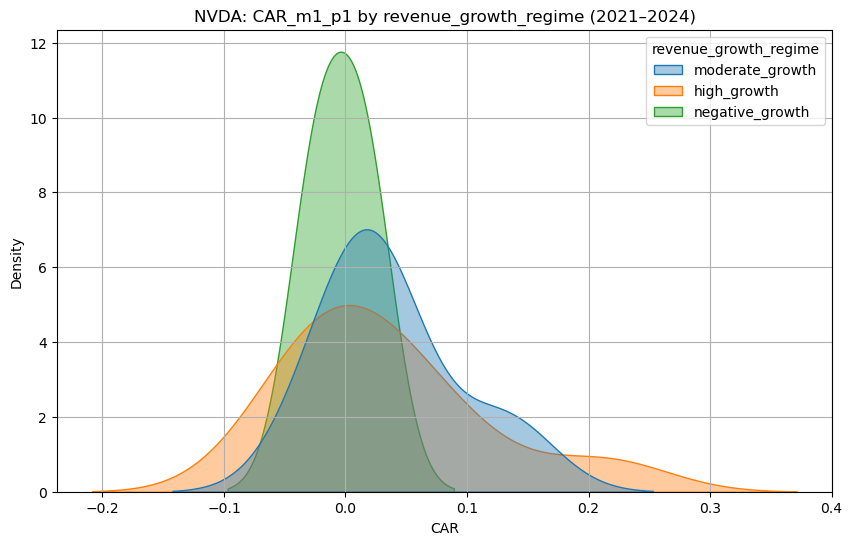

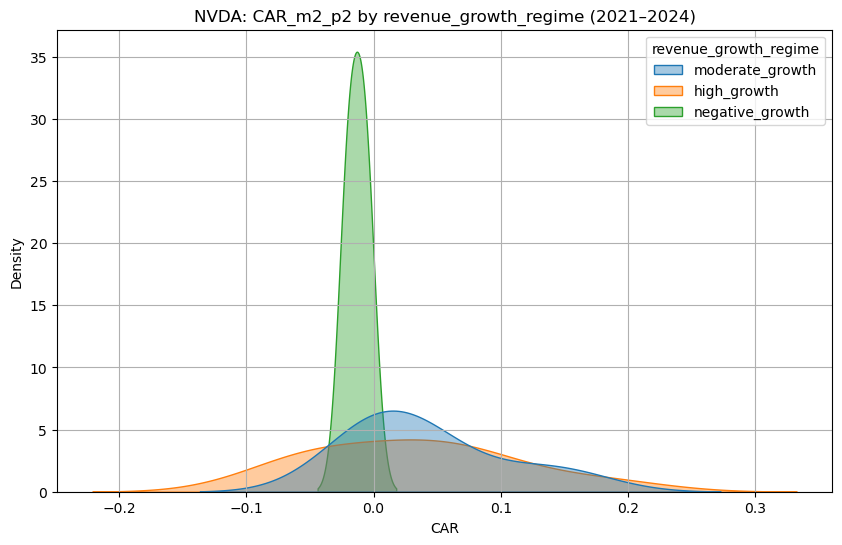

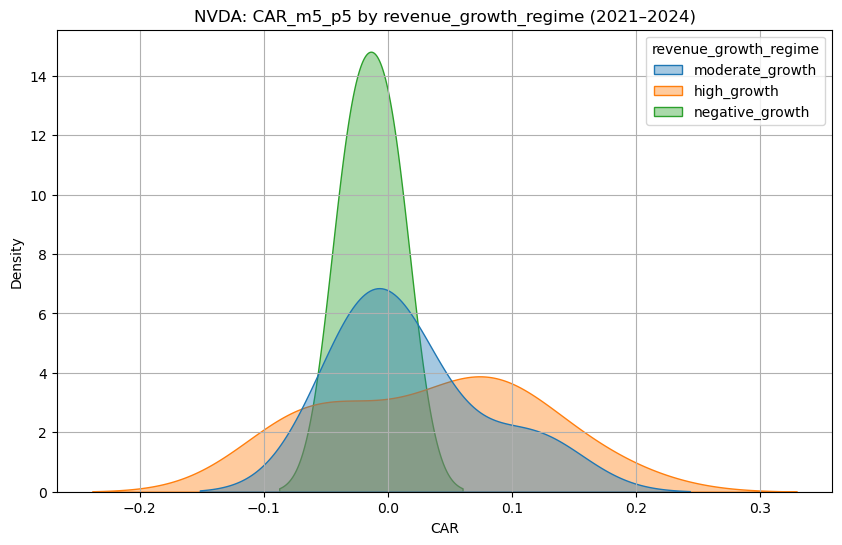

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

car_windows = ["CAR_m1_p1", "CAR_m2_p2", "CAR_m5_p5"]

def plot_recent_car(df_recent, company, metric, car_col):
    df_c = df_recent[df_recent["ticker"] == company]

    plt.figure(figsize=(10,6))
    sns.kdeplot(
        data=df_c,
        x=car_col,
        hue=metric,
        fill=True,
        common_norm=False,
        alpha=0.4
    )
    plt.title(f"{company}: {car_col} by {metric} (2021–2024)")
    plt.xlabel("CAR")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

for company, metric in top_metric_recent.items():
    for car_col in car_windows:
        plot_recent_car(df_recent, company, metric, car_col)

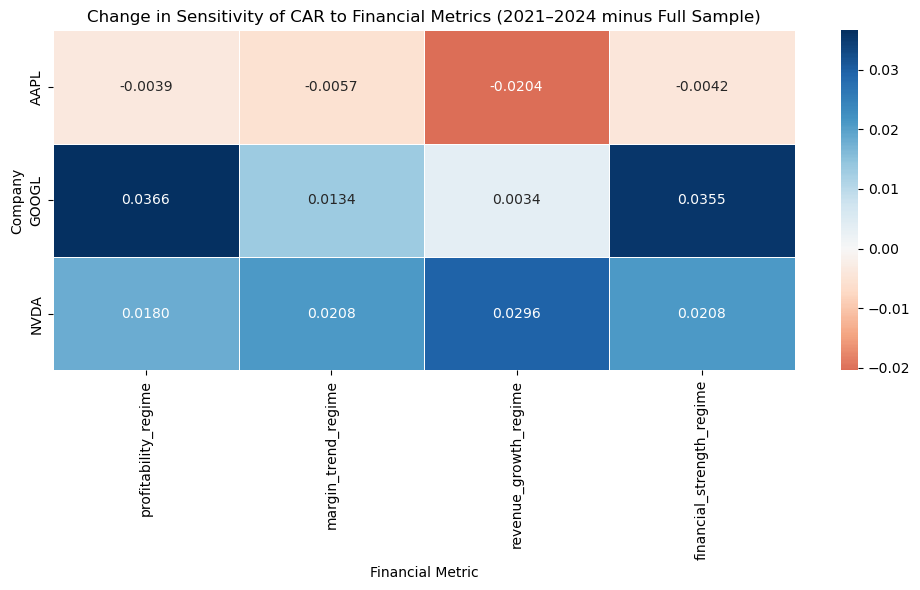

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrames
sens_full_df = pd.DataFrame(sensitivity_scores).T
sens_recent_df = pd.DataFrame(sensitivity_recent).T

# Compute difference
sens_diff_df = sens_recent_df - sens_full_df

plt.figure(figsize=(10, 6))
sns.heatmap(
    sens_diff_df,
    annot=True,
    cmap="RdBu",
    center=0,
    linewidths=0.5,
    fmt=".4f"
)

plt.title("Change in Sensitivity of CAR to Financial Metrics (2021–2024 minus Full Sample)")
plt.xlabel("Financial Metric")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

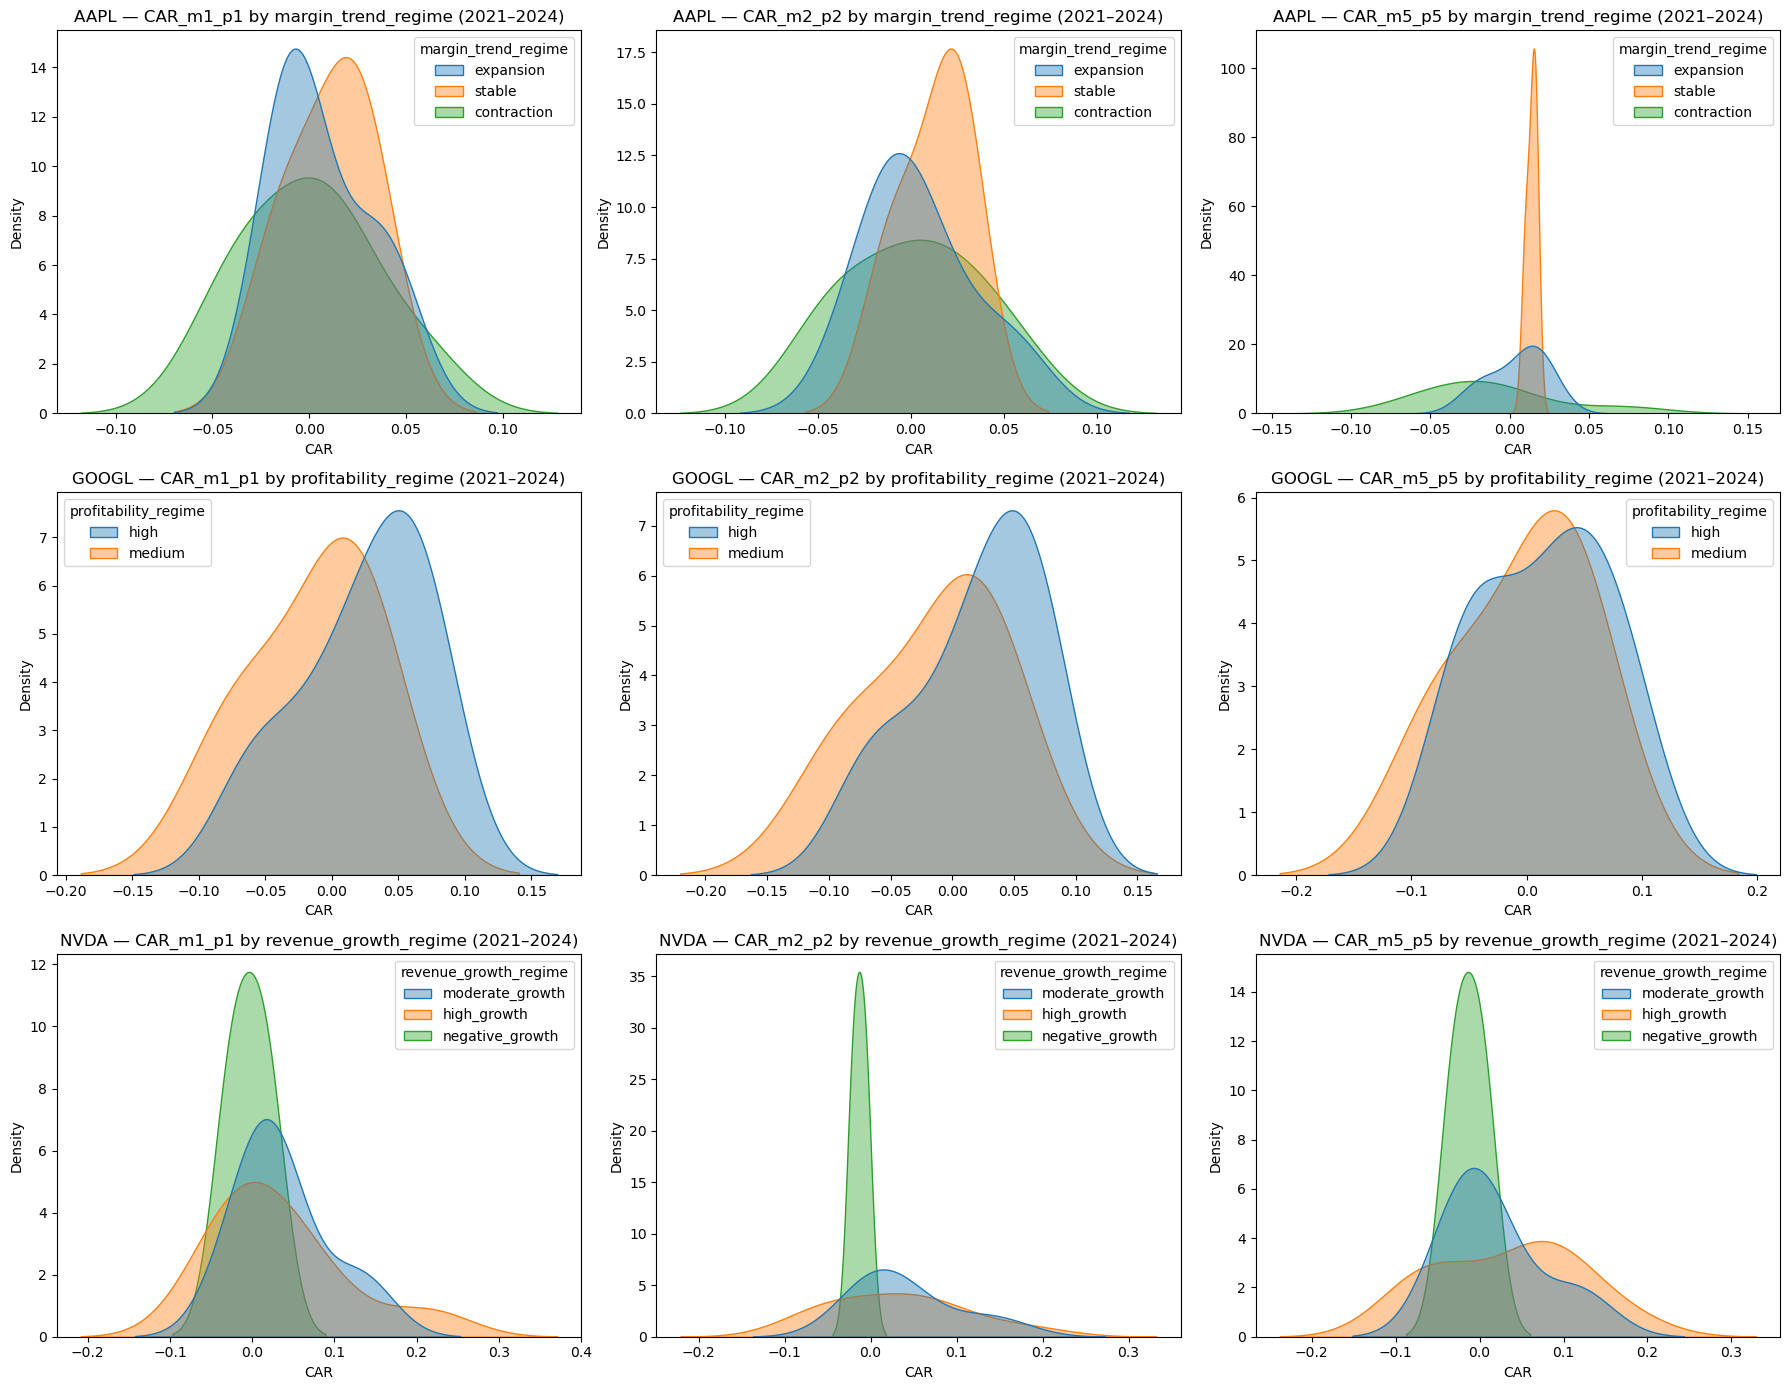

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

car_windows = ["CAR_m1_p1", "CAR_m2_p2", "CAR_m5_p5"]

# Identify top metric per company (recent)
top_metric_recent = {
    company: max(scores, key=scores.get)
    for company, scores in sensitivity_recent.items()
}

# Prepare figure
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
companies = ["AAPL", "GOOGL", "NVDA"]

for i, company in enumerate(companies):
    metric = top_metric_recent[company]
    df_c = df_recent[df_recent["ticker"] == company]

    for j, car_col in enumerate(car_windows):
        ax = axes[i, j]
        sns.kdeplot(
            data=df_c,
            x=car_col,
            hue=metric,
            fill=True,
            common_norm=False,
            alpha=0.4,
            ax=ax
        )
        ax.set_title(f"{company} — {car_col} by {metric} (2021–2024)")
        ax.set_xlabel("CAR")
        ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

In [44]:
df_pre = df[df["reportedDate"].dt.year <= 2020]

sensitivity_pre = {}

for company in ["AAPL", "GOOGL", "NVDA"]:
    df_c = df_pre[df_pre["ticker"] == company]
    sensitivity_pre[company] = {}
    
    for metric in metrics:
        stats = (
            df_c.groupby(metric)[car_cols]
            .agg(["mean", "std", "median"])
        )
        score = stats["CAR_m1_p1"]["mean"].max() - stats["CAR_m1_p1"]["mean"].min()
        sensitivity_pre[company][metric] = score

In [45]:
compare_pre_recent = {}

for company in ["AAPL", "GOOGL", "NVDA"]:
    compare_pre_recent[company] = pd.DataFrame({
        "2005–2020": sensitivity_pre[company],
        "2021–2024": sensitivity_recent[company]
    })

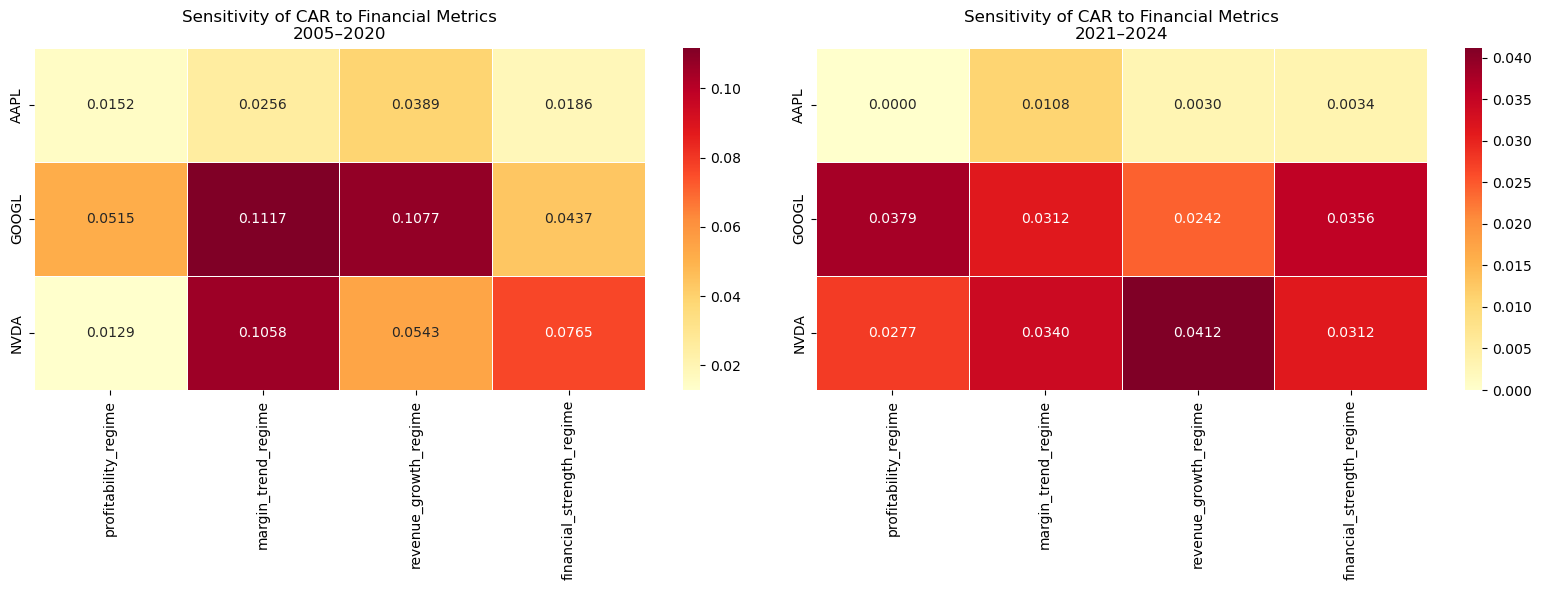

In [46]:
sens_pre_df = pd.DataFrame(sensitivity_pre).T
sens_recent_df = pd.DataFrame(sensitivity_recent).T

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    sens_pre_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f",
    ax=axes[0]
)
axes[0].set_title("Sensitivity of CAR to Financial Metrics\n2005–2020")

sns.heatmap(
    sens_recent_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f",
    ax=axes[1]
)
axes[1].set_title("Sensitivity of CAR to Financial Metrics\n2021–2024")

plt.tight_layout()
plt.show()

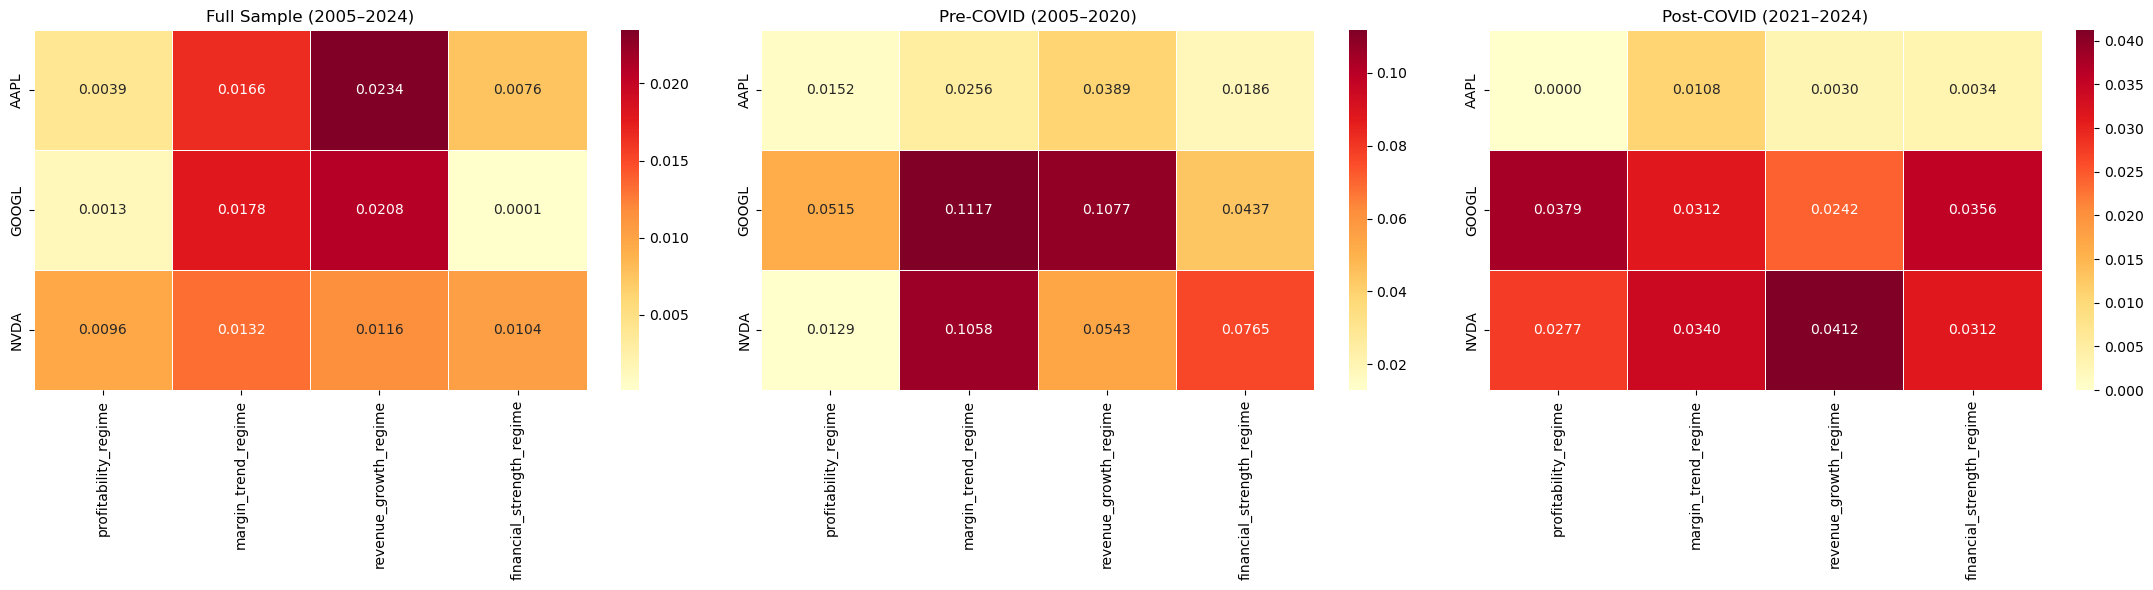

In [47]:
sens_full_df = pd.DataFrame(sensitivity_scores).T

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

sns.heatmap(
    sens_full_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f",
    ax=axes[0]
)
axes[0].set_title("Full Sample (2005–2024)")

sns.heatmap(
    sens_pre_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f",
    ax=axes[1]
)
axes[1].set_title("Pre‑COVID (2005–2020)")

sns.heatmap(
    sens_recent_df,
    annot=True,
    cmap="YlOrRd",
    linewidths=0.5,
    fmt=".4f",
    ax=axes[2]
)
axes[2].set_title("Post‑COVID (2021–2024)")

plt.tight_layout()
plt.show()

Apple (AAPL): From Growth → Margins (with Full Sample as the bridge)
Full Sample (2005–2024)
Revenue growth is the strongest driver of CAR, followed by margin trend. This reflects Apple’s long expansion period where top‑line acceleration mattered most.
Pre‑COVID (2005–2020)
Revenue growth sensitivity is even stronger here — Apple was still in a high‑growth phase, and investors rewarded top‑line momentum.
Post‑COVID (2021–2024)
Revenue growth sensitivity declines, while margin trend becomes the dominant driver. Profitability sensitivity collapses to zero, and financial strength becomes more relevant.
Interpretation
Apple’s earnings reactions have structurally shifted from growth‑driven to margin‑driven.
The full‑sample results sit between the two regimes, masking the post‑COVID pivot toward margins.
Trading implication:
Use margin‑trend signals rather than revenue growth when positioning around AAPL earnings.

Google (GOOGL): From Growth → Efficiency (with Full Sample showing the transition)
Full Sample (2005–2024)
Revenue growth is the strongest predictor of CAR, consistent with Google’s long‑run ad‑driven expansion.
Pre‑COVID (2005–2020)
Revenue growth sensitivity is even stronger, and margin trend is also meaningful. Google was rewarded for scale and top‑line acceleration.
Post‑COVID (2021–2024)
Revenue growth and margin trend sensitivity collapse sharply.
Instead, financial strength and profitability become more influential — reflecting Google’s cost‑cutting, layoffs, and efficiency narrative during 2022–2023.
Interpretation
Google’s earnings reactions have shifted from growth‑driven to efficiency‑driven.
The full‑sample results hide this shift because the pre‑COVID period dominates the data.
Trading implication:
For GOOGL, emphasize balance‑sheet quality and cost discipline, not growth momentum.

NVIDIA (NVDA): From Cyclical Margins → Explosive Growth Sensitivity
Full Sample (2005–2024)
Margin trend is the strongest driver of CAR, reflecting NVIDIA’s cyclical GPU business and sensitivity to product mix.
Pre‑COVID (2005–2020)
Margin trend remains dominant, and revenue growth sensitivity is modest. This matches NVIDIA’s pre‑AI cyclical profile.
Post‑COVID (2021–2024)
Both revenue growth and margin trend sensitivity increase dramatically, with revenue growth becoming the strongest predictor.
This reflects the AI supercycle and unprecedented demand for data‑center GPUs.
Interpretation
NVIDIA undergoes the most dramatic structural break:
from a margin‑sensitive cyclical stock → to a hyper‑growth AI leader.
The full‑sample results understate this shift because the pre‑COVID period dilutes the explosive post‑COVID sensitivity.
Trading implication:
NVDA earnings trades should overweight growth acceleration and margin expansion.